In [44]:
# %% [code]
import pandas as pd
from sklearn.metrics import cohen_kappa_score

file_path = r"E:\test\sleep\Final_results.xlsx"

human1 = pd.read_excel(file_path, sheet_name="human1")
human2 = pd.read_excel(file_path, sheet_name="human2")


In [46]:
model_columns = {
    "Grok": ("Grok.1", "Grok.1"),
    "Claude": ("Claude.1", "Claude.1"),
    "Deepseek": ("Deepseek.1", "DeepSeek"),
    "GPT": ("GPT.1", "GPT.1"),
    "Gemini": ("Gemini.1", "Gemini.1"),
}


In [47]:
kappa_results = {}

for model, (col_h1, col_h2) in model_columns.items():
    scores_h1 = human1[col_h1]
    scores_h2 = human2[col_h2]

    # Drop rows with missing values
    valid = scores_h1.notna() & scores_h2.notna()

    kappa = cohen_kappa_score(
        scores_h1[valid],
        scores_h2[valid],
        weights="quadratic"
    )

    kappa_results[model] = kappa

kappa_results


{'Grok': 0.6489997700620832,
 'Claude': 0.6824660827752018,
 'Deepseek': 0.6118101817583683,
 'GPT': 0.5685415488976824,
 'Gemini': 0.6421130109840335}

In [48]:
all_h1 = []
all_h2 = []

for model, (col_h1, col_h2) in model_columns.items():
    valid = human1[col_h1].notna() & human2[col_h2].notna()
    all_h1.extend(human1.loc[valid, col_h1])
    all_h2.extend(human2.loc[valid, col_h2])

overall_kappa = cohen_kappa_score(
    all_h1,
    all_h2,
    weights="quadratic"
)

overall_kappa


0.6347239525461015

In [34]:
import pandas as pd

file_path = r"E:\test\sleep\Final_results.xlsx"

human1 = pd.read_excel(file_path, sheet_name="human1")
human2 = pd.read_excel(file_path, sheet_name="human2")
info = pd.read_excel(file_path, sheet_name="Info")


In [35]:
model_columns = {
    "Grok": ("Grok.1", "Grok.1"),
    "Claude": ("Claude.1", "Claude.1"),
    "Deepseek": ("Deepseek.1", "DeepSeek"),
    "GPT": ("GPT.1", "GPT.1"),
    "Gemini": ("Gemini.1", "Gemini.1"),
}


In [36]:
final_scores = info.copy()  # keep metadata if needed

for model, (col_h1, col_h2) in model_columns.items():
    final_scores[f"{model}_avg"] = (
        human1[col_h1] + human2[col_h2]
    ) / 2


In [37]:
summary = final_scores[
    [f"{m}_avg" for m in model_columns.keys()]
].agg(["mean", "median", "std"])

summary


,Grok_avg,Claude_avg,Deepseek_avg,GPT_avg,Gemini_avg
mean,3.945736,4.031008,4.136719,4.244094,4.007874
median,5.000000,5.000000,5.000000,5.000000,5.000000
std,1.612016,1.633095,1.550609,1.378500,1.592373


In [38]:
model_means = summary.loc["mean"].sort_values(ascending=False)
model_means


GPT_avg         4.244094
Deepseek_avg    4.136719
Claude_avg      4.031008
Gemini_avg      4.007874
Grok_avg        3.945736
Name: mean, dtype: float64

In [39]:
final_scores.to_excel(
    "Final_results_with_avg_scores.xlsx",
    index=False
)


In [42]:
# %% [code]
import pandas as pd
import numpy as np
from pathlib import Path
from scipy.stats import friedmanchisquare, wilcoxon
from statsmodels.stats.multitest import multipletests

# =========================
# 1) Load NEW excel (avg already inside)
# =========================
FILE_PATH = Path(r"E:\test\sleep\Final_results_with_avg_scores.xlsx")  # <-- change filename
SHEET_NAME = "Info"  # or "info" or "final" depending on your file

df_all = pd.read_excel(FILE_PATH, sheet_name=SHEET_NAME)

print("Loaded:", FILE_PATH.name, "sheet:", SHEET_NAME)
print("Columns:", list(df_all.columns))
print("Shape:", df_all.shape)


Loaded: Final_results_with_avg_scores.xlsx sheet: Info
Columns: ['Publisher', 'Book', 'Publically avalibale', 'Status', 'Clinical specialty', 'Disease diagnosis', 'Differential Diagnosis', 'Patient Text', 'Truth Disease diagnosis', 'Grok', 'Claude', 'Deepseek', 'GPT', 'Gemini', 'Grok_avg', 'Claude_avg', 'Deepseek_avg', 'GPT_avg', 'Gemini_avg']
Shape: (129, 19)


In [43]:
# %% [code]
avg_cols = ["Grok_avg", "Claude_avg", "Deepseek_avg", "GPT_avg", "Gemini_avg"]

missing = [c for c in avg_cols if c not in df_all.columns]
if missing:
    raise KeyError(f"These avg columns are missing in the new sheet: {missing}")

# numeric cleanup
df = df_all[avg_cols].apply(pd.to_numeric, errors="coerce").dropna()

n, k = df.shape
print(f"Cases used for Friedman: n={n}, models k={k}")

stat, p = friedmanchisquare(*[df[c].to_numpy() for c in avg_cols])
kendalls_w = stat / (n * (k - 1))

print("\nFriedman test (global):")
print(f"  chi2 = {stat:.6f}, p = {p:.6g}")
print(f"  Kendall's W = {kendalls_w:.6f}")

# ---- rank-biserial effect size ----
def rank_biserial_from_paired(x, y):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    d = x - y
    d = d[d != 0]
    if d.size == 0:
        return np.nan
    ranks = pd.Series(np.abs(d)).rank(method="average").to_numpy()
    w_plus = ranks[d > 0].sum()
    w_minus = ranks[d < 0].sum()
    denom = w_plus + w_minus
    return np.nan if denom == 0 else (w_plus - w_minus) / denom

# ---- Pairwise Wilcoxon ----
pairs, raw_pvals, effects, med_diffs, n_used = [], [], [], [], []
models = avg_cols[:]  # use same ordering

for i in range(len(models)):
    for j in range(i+1, len(models)):
        a, b = models[i], models[j]
        pair_df = df_all[[a, b]].apply(pd.to_numeric, errors="coerce").dropna()
        x = pair_df[a].to_numpy()
        y = pair_df[b].to_numpy()

        try:
            _, p_val = wilcoxon(x, y, zero_method="wilcox")
        except ValueError:
            p_val = np.nan

        pairs.append(f"{a} vs {b}")
        raw_pvals.append(p_val)
        effects.append(rank_biserial_from_paired(x, y))
        med_diffs.append(np.nanmedian(x - y))
        n_used.append(len(pair_df))

reject, pvals_holm, _, _ = multipletests(raw_pvals, alpha=0.05, method="holm")

results = pd.DataFrame({
    "comparison": pairs,
    "n_pairs": n_used,
    "median_diff(A-B)": med_diffs,
    "p_raw": raw_pvals,
    "p_holm": pvals_holm,
    "significant@0.05": reject,
    "rank_biserial_r": effects,
}).sort_values("p_holm")

print("\nPairwise Wilcoxon (Holm-corrected):")
print(results.to_string(index=False))


Cases used for Friedman: n=126, models k=5

Friedman test (global):
  chi2 = 7.392752, p = 0.116533
  Kendall's W = 0.014668

Pairwise Wilcoxon (Holm-corrected):
                comparison  n_pairs  median_diff(A-B)    p_raw   p_holm  significant@0.05  rank_biserial_r
       Grok_avg vs GPT_avg      127               0.0 0.002383 0.023827              True        -0.540070
     Claude_avg vs GPT_avg      127               0.0 0.020339 0.183049             False        -0.392271
  Grok_avg vs Deepseek_avg      128               0.0 0.023333 0.186664             False        -0.414103
     GPT_avg vs Gemini_avg      127               0.0 0.083376 0.583635             False         0.268687
    Grok_avg vs Gemini_avg      127               0.0 0.678835 1.000000             False        -0.061582
Claude_avg vs Deepseek_avg      128               0.0 0.317417 1.000000             False        -0.179268
  Claude_avg vs Gemini_avg      127               0.0 0.899425 1.000000             False

In [ ]:
FILE_PATH = Path(r"E:\test\sleep\Final_results_with_avg_scores.xlsx")  # <-- change filename


In [25]:
# %% [code]
import pandas as pd
import numpy as np
from pathlib import Path

# ---- Load NEW avg-only file ----
FILE_PATH = Path(r"E:\test\sleep\Final_results_with_avg_scores.xlsx")  # <-- change filename
df_all = pd.read_excel(FILE_PATH, sheet_name="Info")

# ---- Avg score columns ----
avg_cols = ["Grok_avg", "Claude_avg", "Deepseek_avg", "GPT_avg", "Gemini_avg"]

# ---- Safety check ----
missing = [c for c in avg_cols if c not in df_all.columns]
if missing:
    raise KeyError(f"Missing avg columns: {missing}")

# ---- Keep only complete rows across models ----
df = df_all[avg_cols].apply(pd.to_numeric, errors="coerce").dropna()
print("Cases used:", df.shape[0])

# ---- Compute ranks per case (higher score = better → rank 1 is best) ----
ranks = df.rank(axis=1, ascending=False, method="average")

# ---- Mean rank per model ----
mean_ranks = ranks.mean().sort_values()

mean_rank_table = pd.DataFrame({
    "Mean Rank (lower = better)": mean_ranks
})

print("\nMean Ranks:")
print(mean_rank_table)


Cases used: 125

Mean Ranks:
              Mean Rank (lower = better)
GPT_avg                            2.852
Deepseek_avg                       2.928
Gemini_avg                         2.996
Claude_avg                         3.048
Grok_avg                           3.176


In [26]:
# %% [code]
out_path = FILE_PATH.parent / "mean_ranks.csv"
mean_rank_table.to_csv(out_path)
print("Saved:", out_path)


Saved: E:\test\sleep\mean_ranks.csv


In [27]:
# %% [code]
import itertools

models = ["Grok_avg", "Claude_avg", "Deepseek_avg", "GPT_avg", "Gemini_avg"]

df = df_all[models].apply(pd.to_numeric, errors="coerce").dropna()
n_cases = df.shape[0]

rows = []

for a, b in itertools.combinations(models, 2):
    diff = df[a] - df[b]
    win  = (diff > 0).sum()
    tie  = (diff == 0).sum()
    loss = (diff < 0).sum()

    rows.append({
        "Model A": a,
        "Model B": b,
        "A > B": win,
        "A = B": tie,
        "A < B": loss,
        "A > B (%)": win / n_cases * 100,
    })

win_tie_loss = pd.DataFrame(rows)

print("Win / Tie / Loss matrix:")
print(win_tie_loss)


Win / Tie / Loss matrix:
        Model A       Model B  A > B  A = B  A < B  A > B (%)
0      Grok_avg    Claude_avg     21     77     27       16.8
1      Grok_avg  Deepseek_avg     13     86     26       10.4
2      Grok_avg       GPT_avg     13     84     28       10.4
3      Grok_avg    Gemini_avg     24     67     34       19.2
4    Claude_avg  Deepseek_avg     19     85     21       15.2
5    Claude_avg       GPT_avg     16     80     29       12.8
6    Claude_avg    Gemini_avg     21     80     24       16.8
7  Deepseek_avg       GPT_avg     15     91     19       12.0
8  Deepseek_avg    Gemini_avg     27     78     20       21.6
9       GPT_avg    Gemini_avg     29     72     24       23.2


In [28]:
# %% [code]
import pandas as pd
import numpy as np
from scipy.stats import spearmanr, kendalltau

models = ["Grok_avg", "Claude_avg", "Deepseek_avg", "GPT_avg", "Gemini_avg"]

# use complete cases only
df = df_all[models].apply(pd.to_numeric, errors="coerce").dropna()
print("Cases used for agreement:", df.shape[0])

# ---- Spearman correlation matrix ----
spearman_corr = df.corr(method="spearman")

print("\nSpearman correlation matrix:")
print(spearman_corr.round(3))

# ---- Kendall tau matrix ----
kendall_corr = pd.DataFrame(
    index=models,
    columns=models,
    dtype=float
)

for i in models:
    for j in models:
        tau, _ = kendalltau(df[i], df[j])
        kendall_corr.loc[i, j] = tau

print("\nKendall tau correlation matrix:")
print(kendall_corr.round(3))


Cases used for agreement: 125

Spearman correlation matrix:
              Grok_avg  Claude_avg  Deepseek_avg  GPT_avg  Gemini_avg
Grok_avg         1.000       0.644         0.750    0.754       0.443
Claude_avg       0.644       1.000         0.719    0.754       0.654
Deepseek_avg     0.750       0.719         1.000    0.736       0.611
GPT_avg          0.754       0.754         0.736    1.000       0.564
Gemini_avg       0.443       0.654         0.611    0.564       1.000

Kendall tau correlation matrix:
              Grok_avg  Claude_avg  Deepseek_avg  GPT_avg  Gemini_avg
Grok_avg         1.000       0.573         0.687    0.686       0.395
Claude_avg       0.573       1.000         0.656    0.689       0.591
Deepseek_avg     0.687       0.656         1.000    0.683       0.551
GPT_avg          0.686       0.689         0.683    1.000       0.501
Gemini_avg       0.395       0.591         0.551    0.501       1.000


In [29]:
# %% [code]
mean_spearman = spearman_corr.mean().sort_values(ascending=False)
mean_kendall  = kendall_corr.mean().sort_values(ascending=False)

agreement_summary = pd.DataFrame({
    "Mean Spearman ρ": mean_spearman,
    "Mean Kendall τ": mean_kendall
})

print("\nAgreement summary (higher = more concordant):")
print(agreement_summary.round(3))



Agreement summary (higher = more concordant):
              Mean Spearman ρ  Mean Kendall τ
Deepseek_avg            0.763           0.716
GPT_avg                 0.762           0.712
Claude_avg              0.754           0.702
Grok_avg                0.718           0.668
Gemini_avg              0.655           0.608


In [15]:
# %% [code]
import numpy as np
import pandas as pd

models_avg = ["GPT_avg", "Gemini_avg", "Claude_avg", "Grok_avg", "Deepseek_avg"]

# Use complete cases across all models (consistent n)
df = df_all[models_avg].apply(pd.to_numeric, errors="coerce").dropna()
n = len(df)
print("n used:", n)

# Infer score range from data (you can override if you want)
score_min = float(np.nanmin(df.values))
score_max = float(np.nanmax(df.values))
print("Detected score range:", score_min, "to", score_max)

def bootstrap_ci(x, stat_fn=np.mean, n_boot=5000, alpha=0.05, seed=42):
    """Percentile bootstrap CI."""
    x = np.asarray(x, dtype=float)
    x = x[~np.isnan(x)]
    rng = np.random.default_rng(seed)
    if x.size < 2:
        return np.nan, np.nan
    stats = []
    for _ in range(n_boot):
        xb = rng.choice(x, size=x.size, replace=True)
        stats.append(stat_fn(xb))
    lo = np.quantile(stats, alpha/2)
    hi = np.quantile(stats, 1 - alpha/2)
    return float(lo), float(hi)

rows = []
for col in models_avg:
    x = df[col].to_numpy()
    mean = float(np.mean(x))
    sd = float(np.std(x, ddof=1))
    ci_lo, ci_hi = bootstrap_ci(x, stat_fn=np.mean, n_boot=5000, alpha=0.05, seed=123)
    perfect_rate = float(np.mean(x == score_max)) * 100
    zero_rate = float(np.mean(x == score_min)) * 100

    rows.append({
        "LLM": col.replace("_avg",""),
        "Mean": mean,
        "CI_low": ci_lo,
        "CI_high": ci_hi,
        "SD": sd,
        "Perfect rate (%)": perfect_rate,
        "Zero rate (%)": zero_rate,
    })

table1 = pd.DataFrame(rows)

# Rank by Mean (descending): higher mean score = better
table1["Rank"] = table1["Mean"].rank(ascending=False, method="min").astype(int)

# Formatting column like: 4.109 (3.827–4.390)
table1["Mean (95% CI)"] = table1.apply(
    lambda r: f"{r['Mean']:.3f} ({r['CI_low']:.3f}–{r['CI_high']:.3f})", axis=1
)

# Final table order
table1 = table1.sort_values(["Rank", "LLM"])[
    ["LLM", "Mean (95% CI)", "SD", "Perfect rate (%)", "Zero rate (%)", "Rank"]
].reset_index(drop=True)

table1


NameError: name 'df_all' is not defined

In [36]:
# %% [code]
import re

def normalize_specialty(text):
    if pd.isna(text):
        return None
    
    t = str(text).lower().strip()
    t = re.sub(r"[\n\r]", " ", t)
    t = re.sub(r"[.,]", "", t)
    t = re.sub(r"\s+", " ", t)

    # synonym normalization
    t = t.replace("otorhinolaryngology", "ent")
    t = t.replace("otolaryngology", "ent")
    t = t.replace("ear nose and throat", "ent")
    t = t.replace("pulmonolgy", "pulmonology")

    return t


In [37]:
# %% [code]
SECONDARY_DOMAINS = [
    "neurology",
    "pulmonology",
    "psychiatry",
    "ent",
    "psychology",
    "physiotherapy",
    "dentistry",
    "sleep dentistry",
    "anesthesiology",
    "endocrinology",
]

def extract_secondary_domain(text):
    if not text:
        return "Other"

    t = normalize_specialty(text)

    # remove primary domain
    t = t.replace("sleep medicine", "")

    # split on separators
    parts = re.split(r"[,/]| and ", t)

    for p in parts:
        p = p.strip()
        for d in SECONDARY_DOMAINS:
            if d in p:
                return d.title()

    return "Other"


In [38]:
# %% [code]
df_all["Secondary Domain"] = df_all["Clinical specialty"].apply(extract_secondary_domain)

print(df_all["Secondary Domain"].value_counts())


Secondary Domain
Neurology        74
Pulmonology      30
Psychiatry       16
Ent               5
Other             2
Physiotherapy     1
Psychology        1
Name: count, dtype: int64


In [47]:
# %% [code]
import pandas as pd
import re
from pathlib import Path

FILE_PATH = Path(r"E:\test\sleep\Final_results_with_avg_scores_normalized_domains.xlsx")

df_all = pd.read_excel(FILE_PATH, sheet_name="Info")
print("Loaded:", FILE_PATH)
print("Rows:", len(df_all))


Loaded: E:\test\sleep\Final_results_with_avg_scores_normalized_domains.xlsx
Rows: 129


In [48]:
# %% [code]
SECONDARY_DOMAINS = [
    "neurology",
    "pulmonology",
    "psychiatry",
    "ent",
    "psychology",
    "physiotherapy",
    "dentistry",
    "sleep dentistry",
    "anesthesiology",
    "endocrinology",
]

def normalize_specialty(text):
    if pd.isna(text):
        return ""
    
    t = str(text).lower().strip()
    t = re.sub(r"[\n\r]", " ", t)
    t = re.sub(r"[.,]", "", t)
    t = re.sub(r"\s+", " ", t)

    # spelling / synonym fixes
    t = t.replace("pulmonolgy", "pulmonology")
    t = t.replace("otorhinolaryngology", "ent")
    t = t.replace("otolaryngology", "ent")
    t = t.replace("ear nose and throat", "ent")

    return t

def extract_secondary_domain(text):
    t = normalize_specialty(text)

    # remove primary domain
    t = t.replace("sleep medicine", "")

    # split multi-domain strings
    parts = re.split(r"[,/]| and ", t)

    for p in parts:
        p = p.strip()
        for d in SECONDARY_DOMAINS:
            if d in p:
                return d.title()

    return "Other"


In [49]:
# %% [code]
df_all["Secondary_Domain_Normalized"] = (
    df_all["Clinical specialty"]
    .apply(extract_secondary_domain)
)

print("Normalized domain counts:")
print(df_all["Secondary_Domain_Normalized"].value_counts())


Normalized domain counts:
Secondary_Domain_Normalized
Neurology        74
Pulmonology      30
Psychiatry       16
Ent               5
Other             2
Physiotherapy     1
Psychology        1
Name: count, dtype: int64


In [44]:
# %% [code]
OUT_PATH = FILE_PATH.with_name(
    FILE_PATH.stem + "_normalized_domains.xlsx"
)

df_all.to_excel(OUT_PATH, index=False)

print("Saved normalized file to:")
print(OUT_PATH)


Saved normalized file to:
E:\test\sleep\Final_results_with_avg_scores_normalized_domains.xlsx


In [52]:
# %% [code]
import pandas as pd
import numpy as np

models = ["Grok_avg", "Claude_avg", "Deepseek_avg", "GPT_avg", "Gemini_avg"]
domain_col = "Secondary_Domain_Normalized"

#"Clinical specialty"  # secondary domain

# Keep relevant columns only
df = df_all[[domain_col] + models].copy()

# Clean
df[models] = df[models].apply(pd.to_numeric, errors="coerce")
df = df.dropna(subset=models)

print("Domains and case counts:")
print(df[domain_col].value_counts())


Domains and case counts:
Secondary_Domain_Normalized
Neurology        71
Pulmonology      29
Psychiatry       16
Ent               5
Other             2
Physiotherapy     1
Psychology        1
Name: count, dtype: int64


In [53]:
# %% [code]
table2 = (
    df
    .groupby(domain_col)
    .agg(
        Cases=(models[0], "count"),
        **{m.replace("_avg",""): (m, "mean") for m in models}
    )
    .reset_index()
)

# Sort by number of cases (descending)
table2 = table2.sort_values("Cases", ascending=False)

# Round for presentation
for col in table2.columns:
    if col not in [domain_col, "Cases"]:
        table2[col] = table2[col].round(3)

table2


,Secondary_Domain_Normalized,Cases,Grok,Claude,Deepseek,GPT,Gemini
1,Neurology,71,3.937,3.972,4.134,4.176,3.986
6,Pulmonology,29,4.138,4.466,4.379,4.466,4.276
4,Psychiatry,16,3.156,3.031,3.531,3.688,3.562
0,Ent,5,4.800,5.000,4.500,4.800,4.000
2,Other,2,5.000,5.000,5.000,5.000,5.000
3,Physiotherapy,1,5.000,5.000,5.000,5.000,5.000
5,Psychology,1,5.000,5.000,5.000,5.000,5.000


In [54]:
# %% [code]
table2["Note"] = np.where(table2["Cases"] < 5, "Small n (descriptive)", "")
table2


,Secondary_Domain_Normalized,Cases,Grok,Claude,Deepseek,GPT,Gemini,Note
1,Neurology,71,3.937,3.972,4.134,4.176,3.986,
6,Pulmonology,29,4.138,4.466,4.379,4.466,4.276,
4,Psychiatry,16,3.156,3.031,3.531,3.688,3.562,
0,Ent,5,4.800,5.000,4.500,4.800,4.000,
2,Other,2,5.000,5.000,5.000,5.000,5.000,Small n (descriptive)
3,Physiotherapy,1,5.000,5.000,5.000,5.000,5.000,Small n (descriptive)
5,Psychology,1,5.000,5.000,5.000,5.000,5.000,Small n (descriptive)


=== FAILURE COUNT BY MODEL (Score = 0) ===
          Total_Cases  Failures  Failure_Rate_%  Success_Rate_%
GPT               126         7             5.6            94.4
Grok              128        11             8.6            91.4
Gemini            126        11             8.7            91.3
Claude            128        12             9.4            90.6
Deepseek          127        12             9.4            90.6

=== TOP-K ACCURACY BY MODEL ===
          Top-1 (Score=5)  Top-2 (Score≥4)  Top-3 (Score≥3)  Top-4 (Score≥2)  \
Grok                 56.2             72.7             78.9             86.7   
Claude               60.9             75.8             78.1             87.5   
Deepseek             60.6             79.5             82.7             89.8   
GPT                  61.1             81.7             84.9             92.9   
Gemini               56.3             76.2             79.4             87.3   

          Top-5 (Score≥1)  
Grok                 91.4  
Cla

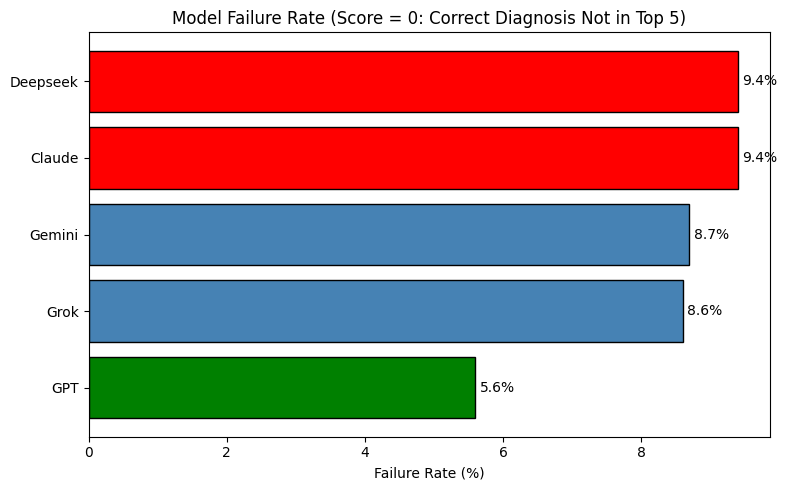

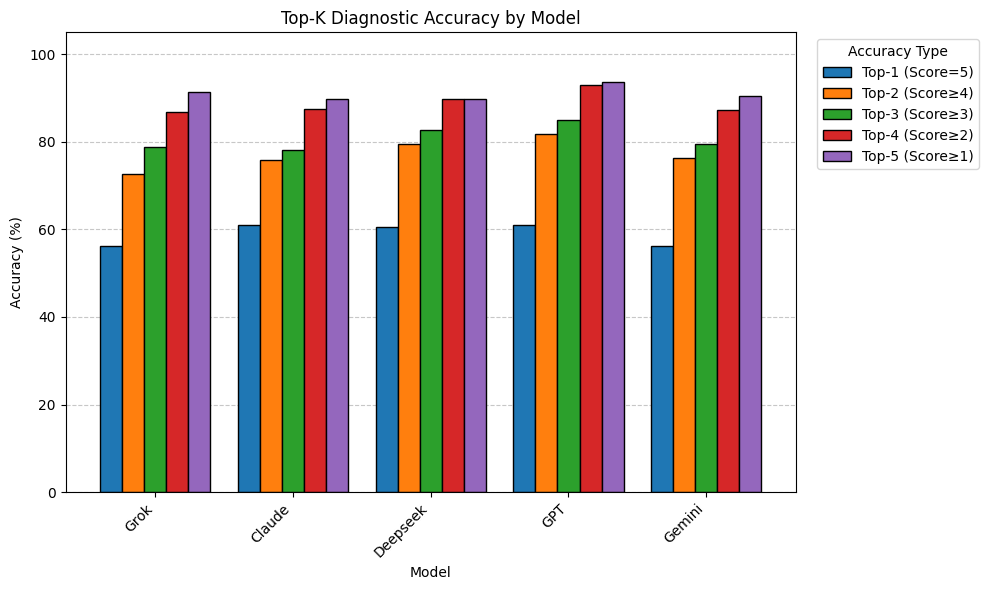

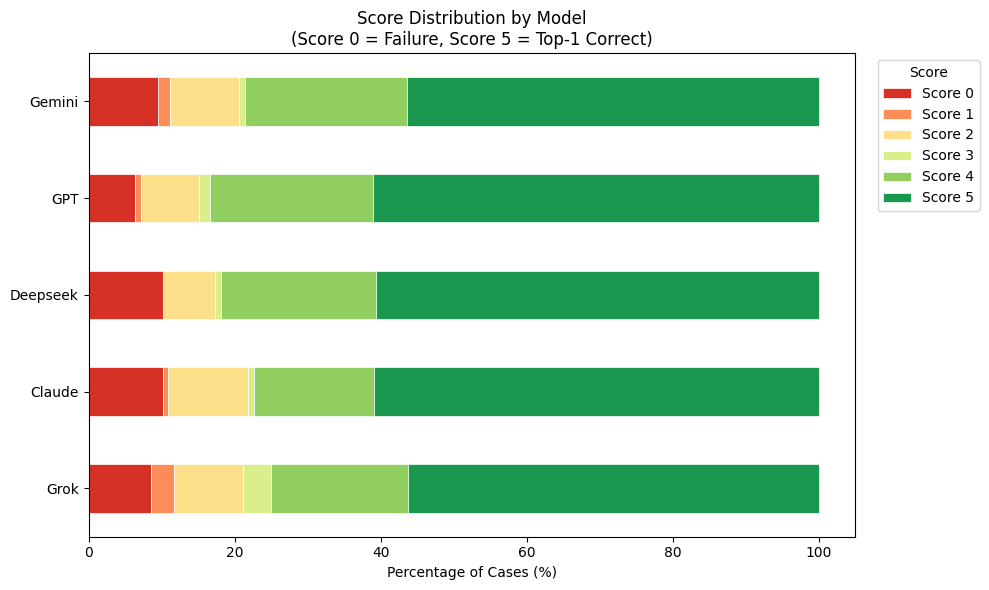


=== NUMBER OF MODELS FAILING PER CASE ===
Models_Failed
0    110
1      7
2      3
3      1
4      3
5      5
Name: count, dtype: int64

Universally difficult cases (ALL models failed): 6
Easy cases (NO model failed): 110
Mixed cases (SOME models failed): 13


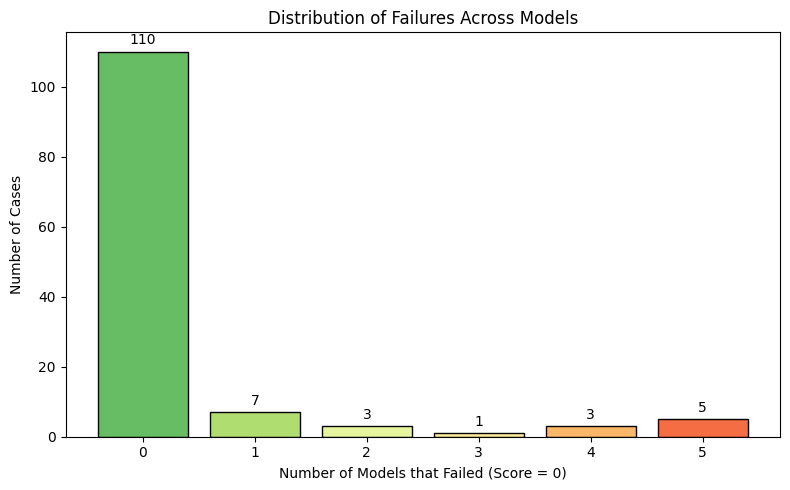

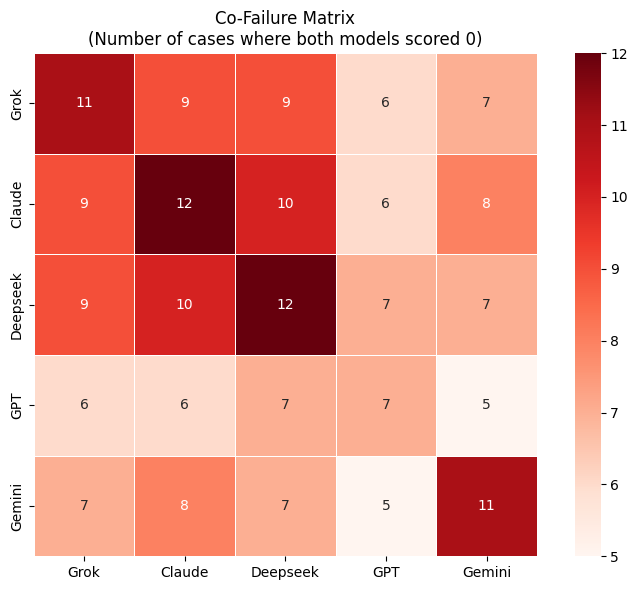


=== FAILURE RATE BY DOMAIN ===
       Domain  Cases  Grok_Fail%  Claude_Fail%  Deepseek_Fail%  GPT_Fail%  Gemini_Fail%
    Neurology     74         9.6           9.6            11.1        8.3           8.3
  Pulmonology     30         3.3           6.7             6.7        0.0           6.9
   Psychiatry     16        18.8          18.8            12.5        6.2          12.5
          Ent      5         0.0           0.0             0.0        0.0          20.0
        Other      2         0.0           0.0             0.0        0.0           0.0
Physiotherapy      1         0.0           0.0             0.0        0.0           0.0
   Psychology      1         0.0           0.0             0.0        0.0           0.0


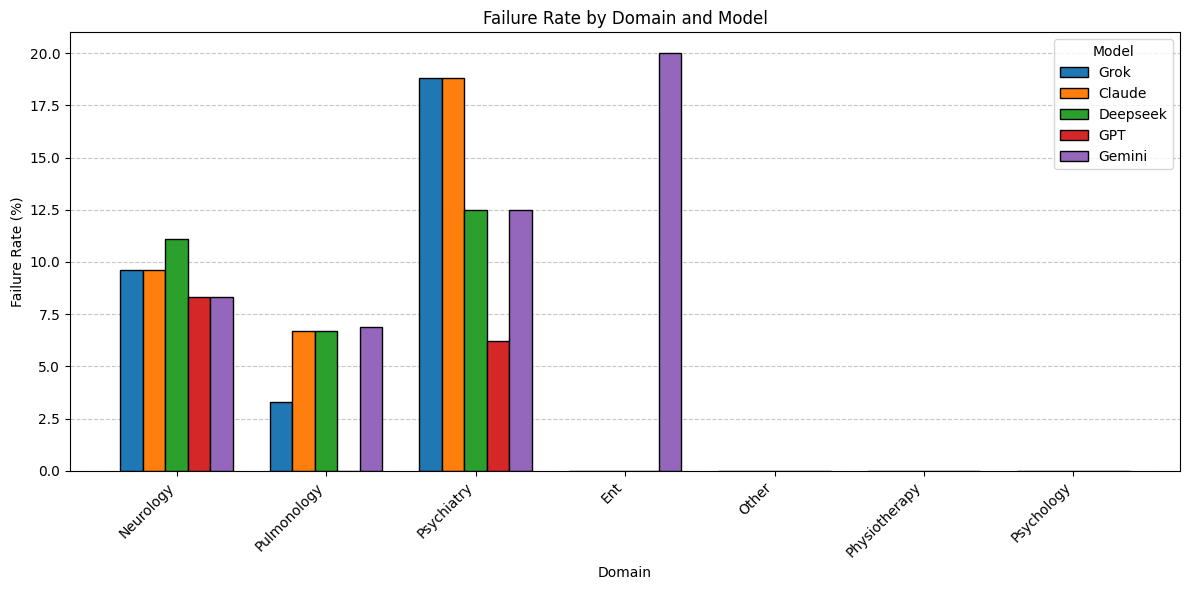


=== CASES WHERE ALL MODELS FAILED ===
    Secondary_Domain_Normalized  Grok_avg  Claude_avg  Deepseek_avg  GPT_avg  Gemini_avg
17                    Neurology       0.0         0.0           0.0      0.0         0.0
23                    Neurology       0.0         0.0           0.0      0.0         0.0
47                  Pulmonology       0.0         0.0           0.0      NaN         NaN
88                   Psychiatry       0.0         0.0           0.0      0.0         0.0
90                    Neurology       0.0         0.0           0.0      0.0         0.0
117                   Neurology       0.0         0.0           0.0      0.0         0.0

=== MODEL-SPECIFIC FAILURES (Only that model failed) ===
   Model  Unique_Failures
  Gemini                3
    Grok                2
  Claude                1
Deepseek                1
     GPT                0


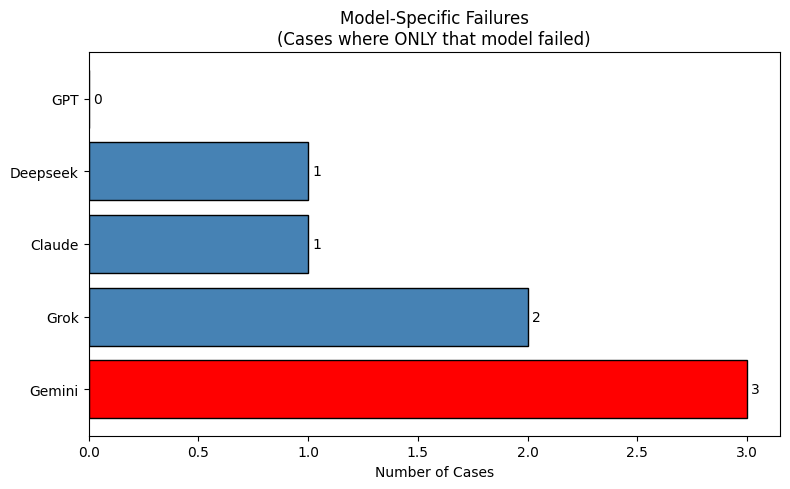


Results exported to 'failure_analysis_results.xlsx'


In [7]:
# %% [code]
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
file_path = r"E:\test\sleep\Final_results_with_avg_scores_normalized_domains.xlsx"
df = pd.read_excel(file_path, sheet_name="Info")

# Model columns
models = ["Grok_avg", "Claude_avg", "Deepseek_avg", "GPT_avg", "Gemini_avg"]

# %% [code]
# === FAILURE ANALYSIS (Score = 0 means failure) ===

# Failure = score of 0 (correct diagnosis NOT in top 5)
for model in models:
    model_name = model.replace("_avg", "")
    df[f"{model_name}_failure"] = df[model] == 0

failure_cols = [f"{m.replace('_avg', '')}_failure" for m in models]

# Count failures per model
print("=== FAILURE COUNT BY MODEL (Score = 0) ===")
failure_counts = df[failure_cols].sum()
valid_counts = df[models].notna().sum()
valid_counts.index = [m.replace("_avg", "") for m in valid_counts.index]

failure_summary = pd.DataFrame({
    "Total_Cases": valid_counts.values,
    "Failures": failure_counts.values,
    "Failure_Rate_%": (failure_counts.values / valid_counts.values * 100).round(1),
    "Success_Rate_%": ((valid_counts.values - failure_counts.values) / valid_counts.values * 100).round(1)
}, index=[m.replace("_avg", "") for m in models])

failure_summary = failure_summary.sort_values("Failure_Rate_%")
print(failure_summary)

# %% [code]
# === TOP-K ACCURACY (Cumulative) ===
# Top-1 = Score 5, Top-2 = Score >= 4, ..., Top-5 = Score >= 1

print("\n=== TOP-K ACCURACY BY MODEL ===")
topk_results = {}

for model in models:
    model_name = model.replace("_avg", "")
    valid_scores = df[model].dropna()
    n = len(valid_scores)
    
    topk_results[model_name] = {
        "Top-1 (Score=5)": (valid_scores == 5).sum() / n * 100,
        "Top-2 (Score≥4)": (valid_scores >= 4).sum() / n * 100,
        "Top-3 (Score≥3)": (valid_scores >= 3).sum() / n * 100,
        "Top-4 (Score≥2)": (valid_scores >= 2).sum() / n * 100,
        "Top-5 (Score≥1)": (valid_scores >= 1).sum() / n * 100,
    }

topk_df = pd.DataFrame(topk_results).T.round(1)
print(topk_df)

# %% [code]
# === VISUALIZATION 1: Failure Rate by Model ===

fig, ax = plt.subplots(figsize=(8, 5))

colors = ['green' if x == failure_summary["Failure_Rate_%"].min() else 
          'red' if x == failure_summary["Failure_Rate_%"].max() else 'steelblue' 
          for x in failure_summary["Failure_Rate_%"]]

bars = ax.barh(failure_summary.index, failure_summary["Failure_Rate_%"], 
               color=colors, edgecolor='black')

ax.set_xlabel("Failure Rate (%)")
ax.set_title("Model Failure Rate (Score = 0: Correct Diagnosis Not in Top 5)")
ax.bar_label(bars, fmt='%.1f%%', padding=3)
plt.tight_layout()
plt.savefig("failure_rate_by_model.png", dpi=300, bbox_inches='tight')
plt.show()

# %% [code]
# === VISUALIZATION 2: Top-K Accuracy Comparison ===

fig, ax = plt.subplots(figsize=(10, 6))

topk_df.plot(kind='bar', ax=ax, edgecolor='black', width=0.8)
ax.set_xlabel("Model")
ax.set_ylabel("Accuracy (%)")
ax.set_title("Top-K Diagnostic Accuracy by Model")
ax.legend(title="Accuracy Type", bbox_to_anchor=(1.02, 1), loc='upper left')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_ylim(0, 105)
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig("topk_accuracy_by_model.png", dpi=300, bbox_inches='tight')
plt.show()

# %% [code]
# === VISUALIZATION 3: Score Distribution (Stacked Bar) ===

fig, ax = plt.subplots(figsize=(10, 6))

score_distributions = {}
for model in models:
    model_name = model.replace("_avg", "")
    valid_scores = df[model].dropna()
    rounded = valid_scores.round().astype(int)
    counts = rounded.value_counts().sort_index()
    full_counts = pd.Series(0, index=range(6))
    for idx in counts.index:
        if 0 <= idx <= 5:
            full_counts[idx] = counts[idx]
    score_distributions[model_name] = full_counts / len(valid_scores) * 100

score_df = pd.DataFrame(score_distributions).T
score_df.columns = [f"Score {i}" for i in range(6)]

# Reorder: Failure (0) in red, then gradient for success
colors = ['#d73027', '#fc8d59', '#fee08b', '#d9ef8b', '#91cf60', '#1a9850']
score_df.plot(kind='barh', stacked=True, color=colors, ax=ax, edgecolor='white', linewidth=0.5)

ax.set_xlabel("Percentage of Cases (%)")
ax.set_title("Score Distribution by Model\n(Score 0 = Failure, Score 5 = Top-1 Correct)")
ax.legend(title="Score", bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.savefig("score_distribution_by_model.png", dpi=300, bbox_inches='tight')
plt.show()

# %% [code]
# === FAILURE OVERLAP ANALYSIS ===

df["Models_Failed"] = df[failure_cols].sum(axis=1)
df["Valid_Models"] = df[models].notna().sum(axis=1)

print("\n=== NUMBER OF MODELS FAILING PER CASE ===")
fail_distribution = df["Models_Failed"].value_counts().sort_index()
print(fail_distribution)

# Cases where ALL models failed
universal_failures = df[(df["Models_Failed"] == df["Valid_Models"]) & (df["Models_Failed"] > 0)]
print(f"\nUniversally difficult cases (ALL models failed): {len(universal_failures)}")

# Cases where NO model failed
no_failures = df[df["Models_Failed"] == 0]
print(f"Easy cases (NO model failed): {len(no_failures)}")

# Cases where SOME models failed
some_failures = df[(df["Models_Failed"] > 0) & (df["Models_Failed"] < df["Valid_Models"])]
print(f"Mixed cases (SOME models failed): {len(some_failures)}")

# %% [code]
# === VISUALIZATION 4: Failure Distribution Across Models ===

fig, ax = plt.subplots(figsize=(8, 5))

fail_counts = df["Models_Failed"].value_counts().sort_index()
colors_gradient = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(fail_counts)))

bars = ax.bar(fail_counts.index, fail_counts.values, color=colors_gradient, edgecolor='black')
ax.set_xlabel("Number of Models that Failed (Score = 0)")
ax.set_ylabel("Number of Cases")
ax.set_title("Distribution of Failures Across Models")
ax.set_xticks(range(6))
ax.bar_label(bars, padding=3)

plt.tight_layout()
plt.savefig("failure_distribution_across_models.png", dpi=300, bbox_inches='tight')
plt.show()

# %% [code]
# === VISUALIZATION 5: Co-Failure Heatmap ===

failure_matrix = df[failure_cols].astype(int)
failure_matrix.columns = [c.replace("_failure", "") for c in failure_cols]

co_failure = failure_matrix.T.dot(failure_matrix)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(co_failure, annot=True, fmt='d', cmap='Reds', ax=ax, 
            square=True, linewidths=0.5)
ax.set_title("Co-Failure Matrix\n(Number of cases where both models scored 0)")
plt.tight_layout()
plt.savefig("co_failure_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()

# %% [code]
# === FAILURE RATE BY DOMAIN ===

domain_col = "Secondary_Domain_Normalized"  # Adjust if different column name

if domain_col in df.columns:
    print("\n=== FAILURE RATE BY DOMAIN ===")
    
    domain_failure = []
    for domain in df[domain_col].dropna().unique():
        domain_df = df[df[domain_col] == domain]
        n_cases = len(domain_df)
        
        row = {"Domain": domain, "Cases": n_cases}
        for model in models:
            model_name = model.replace("_avg", "")
            valid = domain_df[model].notna()
            failures = (domain_df.loc[valid.values, model] == 0).sum()
            row[f"{model_name}_Fail%"] = (failures / valid.sum() * 100).round(1) if valid.sum() > 0 else np.nan
        
        domain_failure.append(row)
    
    domain_failure_df = pd.DataFrame(domain_failure)
    domain_failure_df = domain_failure_df.sort_values("Cases", ascending=False)
    print(domain_failure_df.to_string(index=False))
    
    # Visualization
    fig, ax = plt.subplots(figsize=(12, 6))
    
    fail_cols_plot = [c for c in domain_failure_df.columns if "_Fail%" in c]
    x = np.arange(len(domain_failure_df))
    width = 0.15
    
    for i, col in enumerate(fail_cols_plot):
        offset = (i - len(fail_cols_plot)/2 + 0.5) * width
        ax.bar(x + offset, domain_failure_df[col], width, 
               label=col.replace("_Fail%", ""), edgecolor='black')
    
    ax.set_xlabel("Domain")
    ax.set_ylabel("Failure Rate (%)")
    ax.set_title("Failure Rate by Domain and Model")
    ax.set_xticks(x)
    ax.set_xticklabels(domain_failure_df["Domain"], rotation=45, ha='right')
    ax.legend(title="Model")
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    ax.set_axisbelow(True)
    
    plt.tight_layout()
    plt.savefig("failure_rate_by_domain.png", dpi=300, bbox_inches='tight')
    plt.show()

# %% [code]
# === HARDEST CASES (Universal Failures) ===

print("\n=== CASES WHERE ALL MODELS FAILED ===")
if len(universal_failures) > 0:
    display_cols = [domain_col] + models if domain_col in df.columns else models
    print(universal_failures[display_cols].to_string())
else:
    print("No cases where all models failed!")

# %% [code]
# === MODEL-SPECIFIC FAILURES ===
# Cases where only ONE specific model failed

print("\n=== MODEL-SPECIFIC FAILURES (Only that model failed) ===")
model_specific = {}

for model in models:
    model_name = model.replace("_avg", "")
    fail_col = f"{model_name}_failure"
    other_fail_cols = [c for c in failure_cols if c != fail_col]
    
    # This model failed, but no other model failed
    specific_failures = df[df[fail_col] & ~df[other_fail_cols].any(axis=1)]
    model_specific[model_name] = len(specific_failures)

model_specific_df = pd.DataFrame({
    "Model": model_specific.keys(),
    "Unique_Failures": model_specific.values()
}).sort_values("Unique_Failures", ascending=False)

print(model_specific_df.to_string(index=False))

# Visualization
fig, ax = plt.subplots(figsize=(8, 5))
colors = ['red' if x == max(model_specific.values()) else 'steelblue' 
          for x in model_specific_df["Unique_Failures"]]
bars = ax.barh(model_specific_df["Model"], model_specific_df["Unique_Failures"], 
               color=colors, edgecolor='black')
ax.set_xlabel("Number of Cases")
ax.set_title("Model-Specific Failures\n(Cases where ONLY that model failed)")
ax.bar_label(bars, padding=3)
plt.tight_layout()
plt.savefig("model_specific_failures.png", dpi=300, bbox_inches='tight')
plt.show()

# %% [code]
# === EXPORT RESULTS ===

with pd.ExcelWriter("failure_analysis_results.xlsx") as writer:
    # Failure summary
    failure_summary.to_excel(writer, sheet_name="Failure_Summary")
    
    # Top-K accuracy
    topk_df.to_excel(writer, sheet_name="TopK_Accuracy")
    
    # Score distribution
    score_df.to_excel(writer, sheet_name="Score_Distribution")
    
    # Failure by domain
    if domain_col in df.columns:
        domain_failure_df.to_excel(writer, sheet_name="Failure_by_Domain", index=False)
    
    # Universal failures
    if len(universal_failures) > 0:
        display_cols = [domain_col] + models if domain_col in df.columns else models
        universal_failures[display_cols].to_excel(writer, sheet_name="Universal_Failures", index=False)
    
    # Model-specific failures
    model_specific_df.to_excel(writer, sheet_name="Model_Specific_Failures", index=False)

print("\nResults exported to 'failure_analysis_results.xlsx'")


=== TOP-K ACCURACY BY MODEL ===
          Top-1 (Score=5)  Top-2 (Score≥4)  Top-3 (Score≥3)  Top-4 (Score≥2)  \
Grok                 56.2             72.7             78.9             86.7   
Claude               60.9             75.8             78.1             87.5   
Deepseek             60.6             79.5             82.7             89.8   
GPT                  61.1             81.7             84.9             92.9   
Gemini               56.3             76.2             79.4             87.3   

          Top-5 (Score≥1)  
Grok                 91.4  
Claude               89.8  
Deepseek             89.8  
GPT                  93.7  
Gemini               90.5  


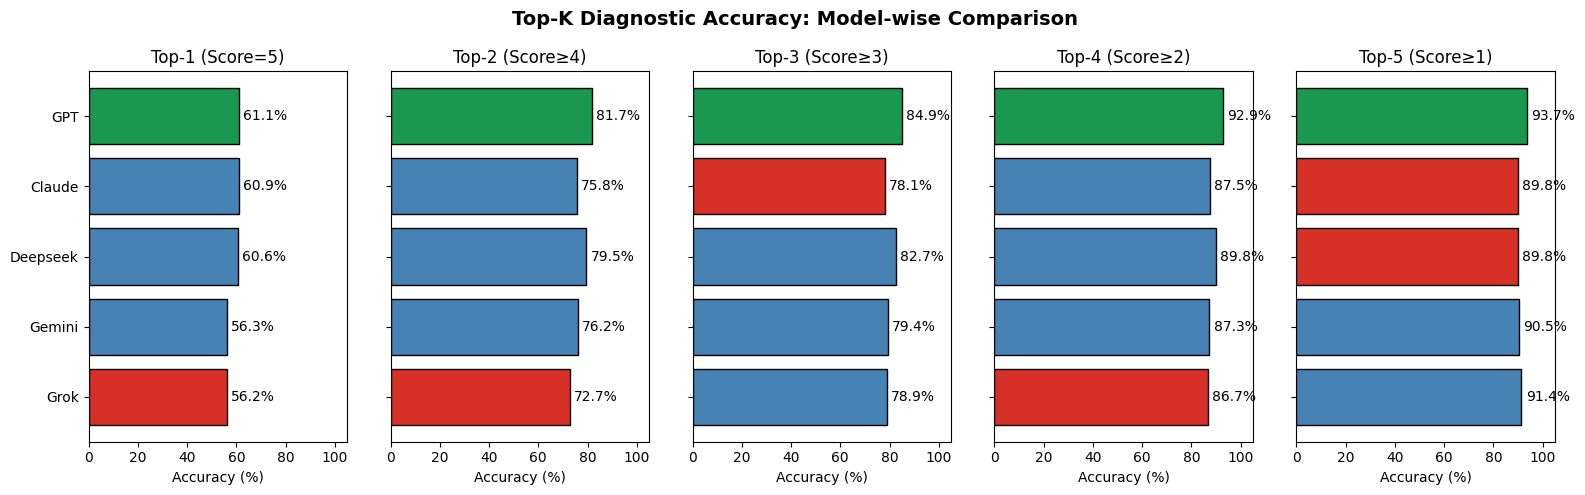

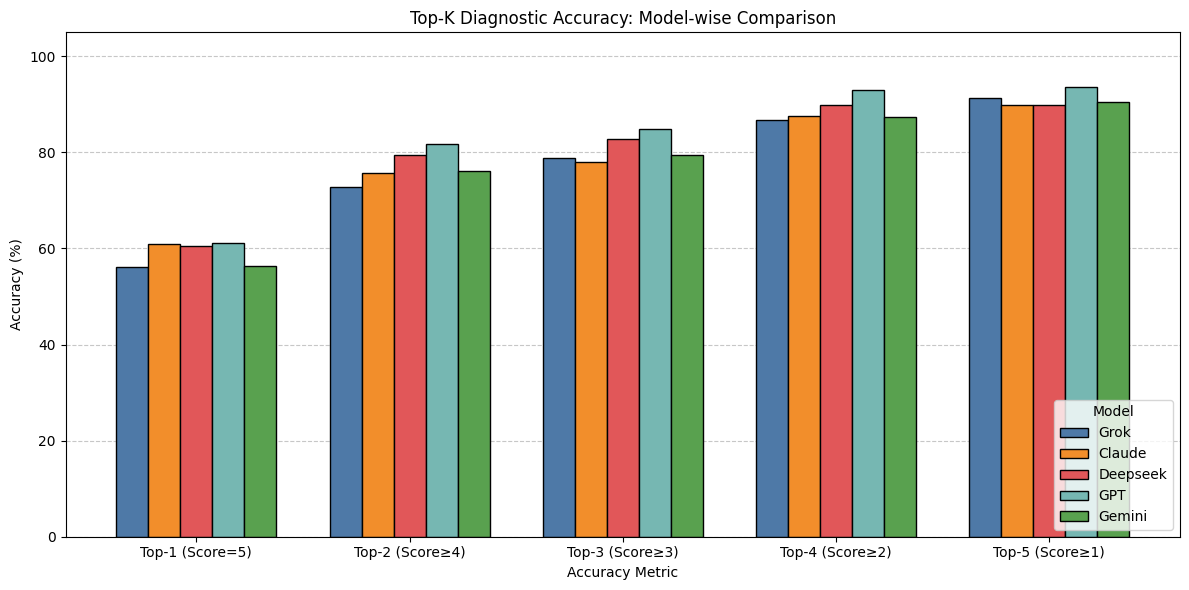

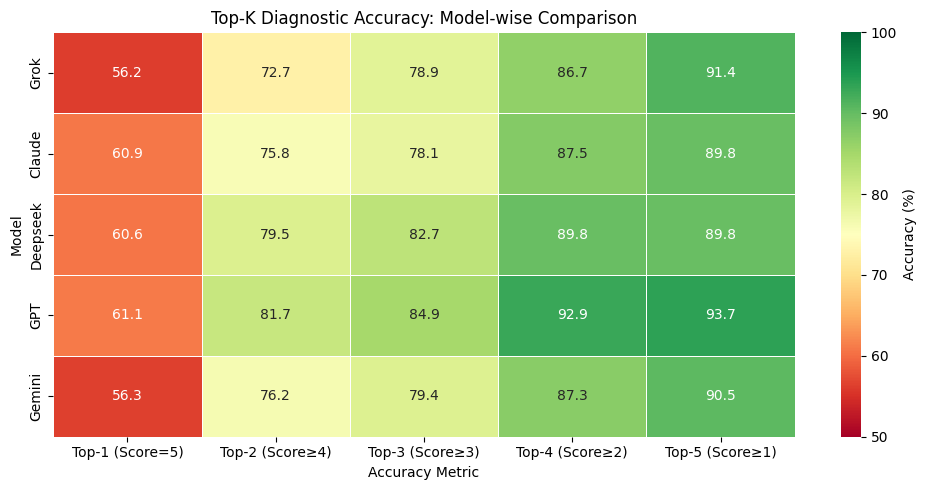


=== BEST & WORST MODEL PER TOP-K ===
         Metric Best_Model  Best_Score Worst_Model  Worst_Score  Difference
Top-1 (Score=5)        GPT        61.1        Grok         56.2         4.9
Top-2 (Score≥4)        GPT        81.7        Grok         72.7         9.0
Top-3 (Score≥3)        GPT        84.9      Claude         78.1         6.8
Top-4 (Score≥2)        GPT        92.9        Grok         86.7         6.2
Top-5 (Score≥1)        GPT        93.7      Claude         89.8         3.9

=== MODEL RANKING PER TOP-K (1 = Best) ===
          Top-1 (Score=5)  Top-2 (Score≥4)  Top-3 (Score≥3)  Top-4 (Score≥2)  \
Grok                    5                5                4                5   
Claude                  2                4                5                3   
Deepseek                3                2                2                2   
GPT                     1                1                1                1   
Gemini                  4                3                3   

In [8]:
# %% [code]
# === TOP-K ACCURACY (Model-wise Comparison) ===

print("\n=== TOP-K ACCURACY BY MODEL ===")
topk_results = {}

for model in models:
    model_name = model.replace("_avg", "")
    valid_scores = df[model].dropna()
    n = len(valid_scores)
    
    topk_results[model_name] = {
        "Top-1 (Score=5)": (valid_scores == 5).sum() / n * 100,
        "Top-2 (Score≥4)": (valid_scores >= 4).sum() / n * 100,
        "Top-3 (Score≥3)": (valid_scores >= 3).sum() / n * 100,
        "Top-4 (Score≥2)": (valid_scores >= 2).sum() / n * 100,
        "Top-5 (Score≥1)": (valid_scores >= 1).sum() / n * 100,
    }

topk_df = pd.DataFrame(topk_results).T.round(1)
print(topk_df)

# %% [code]
# === VISUALIZATION: Top-K Accuracy Model-wise Comparison ===

fig, axes = plt.subplots(1, 5, figsize=(16, 5), sharey=True)

topk_columns = topk_df.columns.tolist()

for i, topk in enumerate(topk_columns):
    ax = axes[i]
    
    # Sort by accuracy for this Top-K
    sorted_data = topk_df[topk].sort_values(ascending=True)
    
    # Color: best = green, worst = red, others = steelblue
    colors = []
    for val in sorted_data.values:
        if val == sorted_data.max():
            colors.append('#1a9850')  # green
        elif val == sorted_data.min():
            colors.append('#d73027')  # red
        else:
            colors.append('steelblue')
    
    bars = ax.barh(sorted_data.index, sorted_data.values, color=colors, edgecolor='black')
    ax.set_xlabel("Accuracy (%)")
    ax.set_title(topk)
    ax.bar_label(bars, fmt='%.1f%%', padding=3)
    ax.set_xlim(0, 105)

fig.suptitle("Top-K Diagnostic Accuracy: Model-wise Comparison", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig("topk_accuracy_modelwise.png", dpi=300, bbox_inches='tight')
plt.show()

# %% [code]
# === ALTERNATIVE: Single Grouped Bar Chart ===

fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(topk_columns))
width = 0.15
model_names = topk_df.index.tolist()

colors = ['#4e79a7', '#f28e2b', '#e15759', '#76b7b2', '#59a14f']

for i, model in enumerate(model_names):
    offset = (i - len(model_names)/2 + 0.5) * width
    bars = ax.bar(x + offset, topk_df.loc[model], width, 
                  label=model, color=colors[i], edgecolor='black')

ax.set_xlabel("Accuracy Metric")
ax.set_ylabel("Accuracy (%)")
ax.set_title("Top-K Diagnostic Accuracy: Model-wise Comparison")
ax.set_xticks(x)
ax.set_xticklabels(topk_columns)
ax.legend(title="Model", loc='lower right')
ax.set_ylim(0, 105)
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig("topk_accuracy_grouped.png", dpi=300, bbox_inches='tight')
plt.show()

# %% [code]
# === HEATMAP VERSION ===

fig, ax = plt.subplots(figsize=(10, 5))

sns.heatmap(topk_df, annot=True, fmt='.1f', cmap='RdYlGn', ax=ax,
            linewidths=0.5, vmin=50, vmax=100, cbar_kws={'label': 'Accuracy (%)'})

ax.set_title("Top-K Diagnostic Accuracy: Model-wise Comparison")
ax.set_xlabel("Accuracy Metric")
ax.set_ylabel("Model")

plt.tight_layout()
plt.savefig("topk_accuracy_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()

# %% [code]
# === SUMMARY TABLE: Best/Worst Model per Top-K ===

print("\n=== BEST & WORST MODEL PER TOP-K ===")
summary_comparison = pd.DataFrame({
    "Metric": topk_columns,
    "Best_Model": [topk_df[col].idxmax() for col in topk_columns],
    "Best_Score": [topk_df[col].max() for col in topk_columns],
    "Worst_Model": [topk_df[col].idxmin() for col in topk_columns],
    "Worst_Score": [topk_df[col].min() for col in topk_columns],
    "Difference": [topk_df[col].max() - topk_df[col].min() for col in topk_columns]
})
print(summary_comparison.to_string(index=False))

# %% [code]
# === RANKING TABLE ===

print("\n=== MODEL RANKING PER TOP-K (1 = Best) ===")
ranking_df = topk_df.rank(ascending=False, method='min').astype(int)
print(ranking_df)

# Average rank across all Top-K metrics
ranking_df["Avg_Rank"] = ranking_df.mean(axis=1).round(2)
ranking_df = ranking_df.sort_values("Avg_Rank")
print("\n=== OVERALL RANKING (by Average Rank) ===")
print(ranking_df)


=== TOP-K ACCURACY BY MODEL ===
          Top-1  Top-2  Top-3  Top-4  Top-5
Grok       56.2   72.7   78.9   86.7   91.4
Claude     60.9   75.8   78.1   87.5   89.8
Deepseek   60.6   79.5   82.7   89.8   89.8
GPT        61.1   81.7   84.9   92.9   93.7
Gemini     56.3   76.2   79.4   87.3   90.5


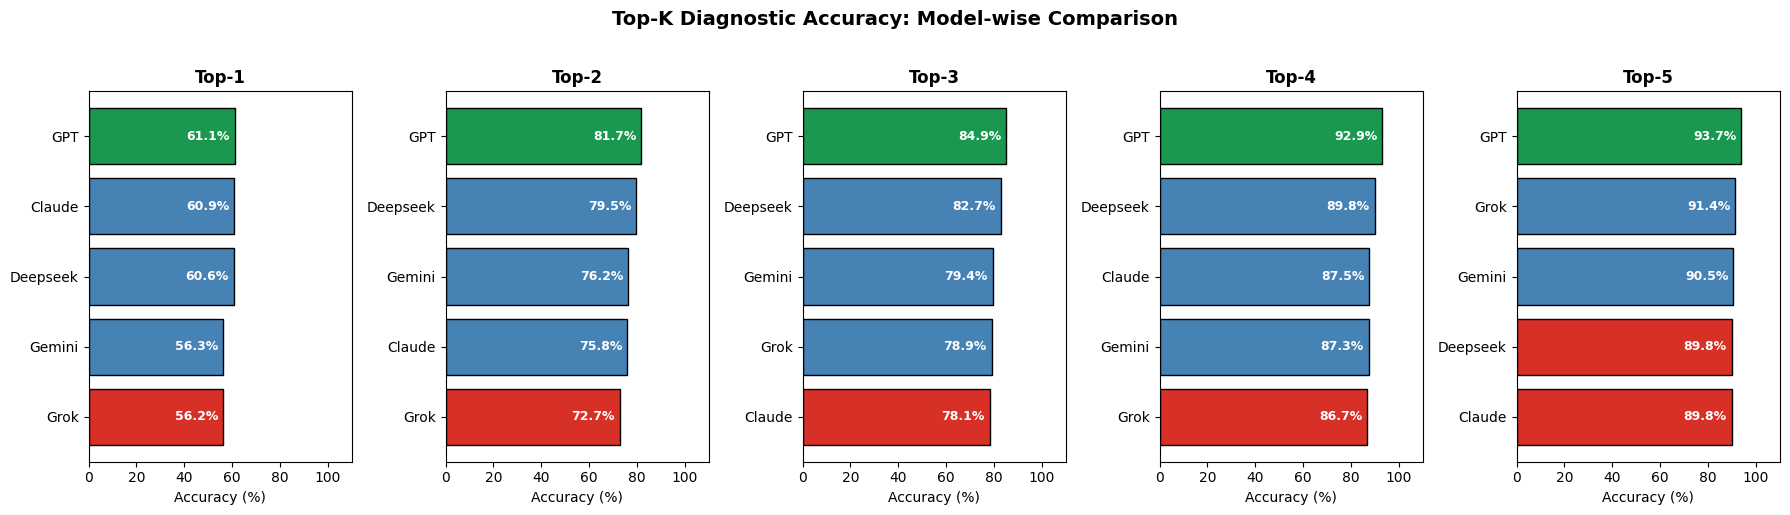

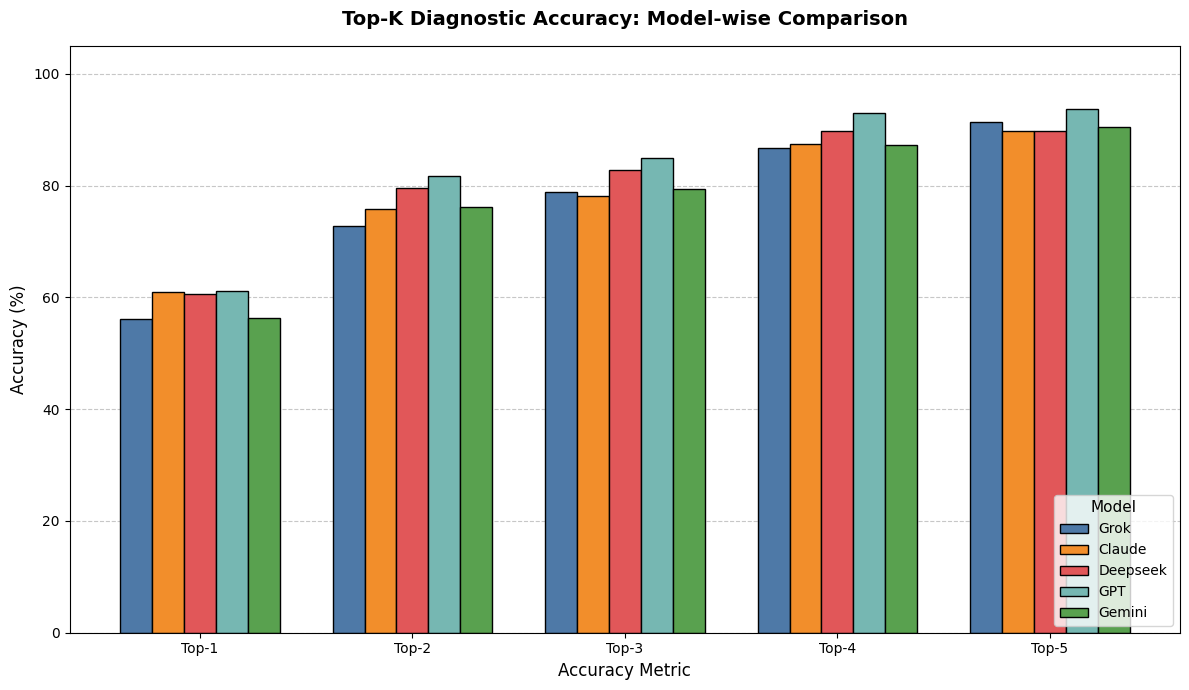

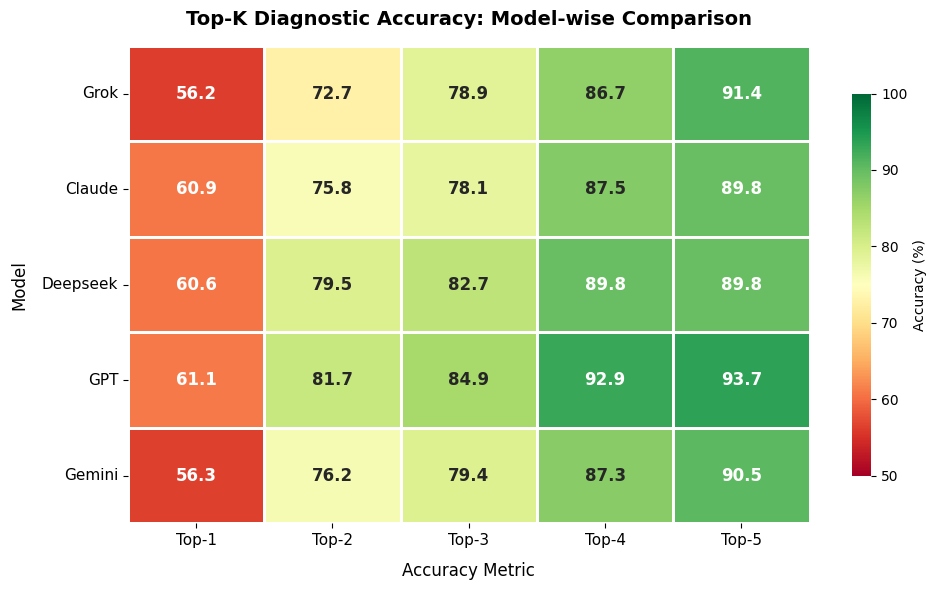

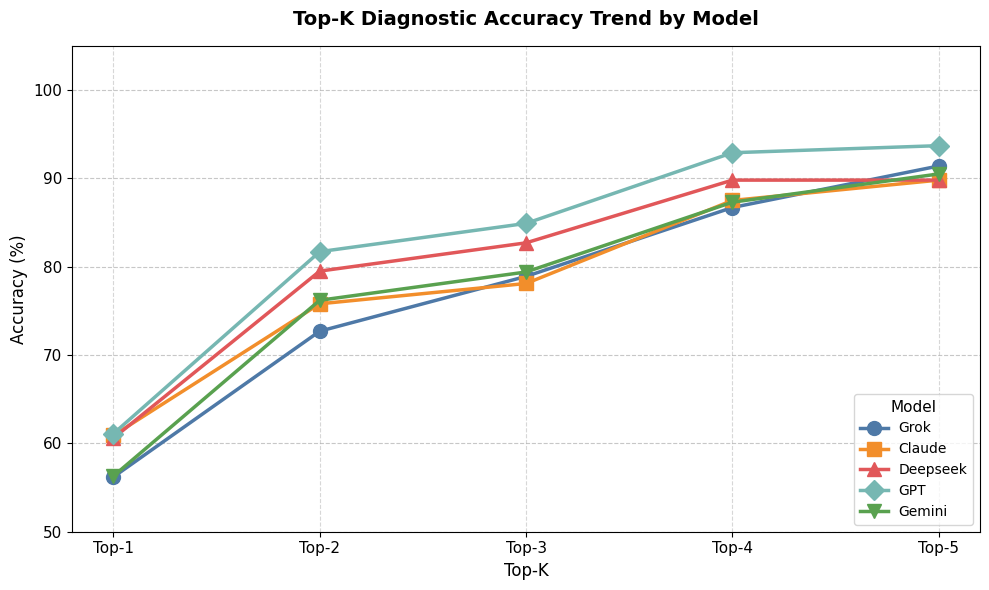


=== BEST & WORST MODEL PER TOP-K ===
Metric Best_Model  Best_Score Worst_Model  Worst_Score  Difference
 Top-1        GPT        61.1        Grok         56.2         4.9
 Top-2        GPT        81.7        Grok         72.7         9.0
 Top-3        GPT        84.9      Claude         78.1         6.8
 Top-4        GPT        92.9        Grok         86.7         6.2
 Top-5        GPT        93.7      Claude         89.8         3.9

=== MODEL RANKING PER TOP-K (1 = Best) ===
          Top-1  Top-2  Top-3  Top-4  Top-5
Grok          5      5      4      5      2
Claude        2      4      5      3      4
Deepseek      3      2      2      2      4
GPT           1      1      1      1      1
Gemini        4      3      3      4      3

=== OVERALL RANKING (by Average Rank) ===
          Top-1  Top-2  Top-3  Top-4  Top-5  Avg_Rank
GPT           1      1      1      1      1       1.0
Deepseek      3      2      2      2      4       2.6
Gemini        4      3      3      4      3    

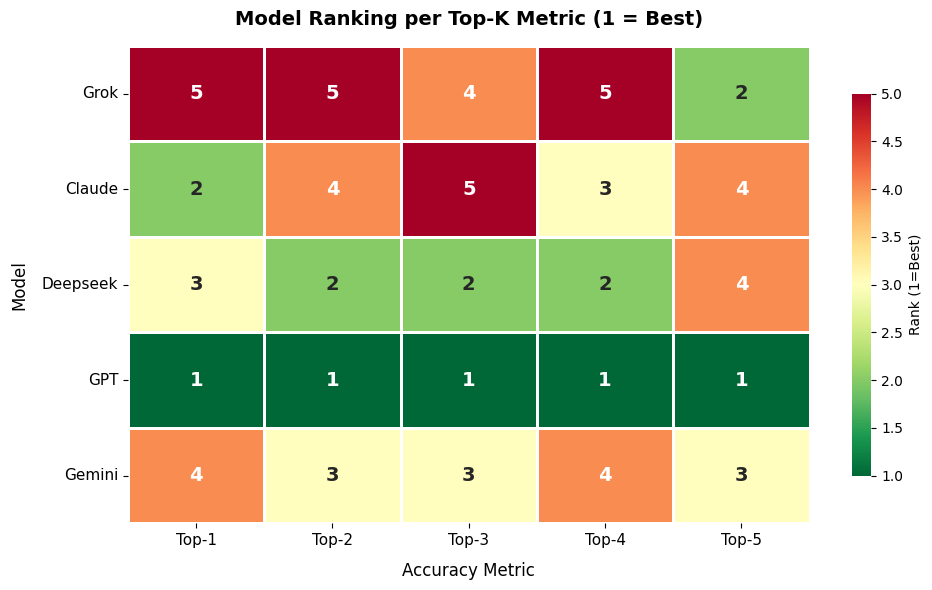

In [9]:
# %% [code]
# === TOP-K ACCURACY (Model-wise Comparison) ===

print("\n=== TOP-K ACCURACY BY MODEL ===")
topk_results = {}

for model in models:
    model_name = model.replace("_avg", "")
    valid_scores = df[model].dropna()
    n = len(valid_scores)
    
    topk_results[model_name] = {
        "Top-1": (valid_scores == 5).sum() / n * 100,
        "Top-2": (valid_scores >= 4).sum() / n * 100,
        "Top-3": (valid_scores >= 3).sum() / n * 100,
        "Top-4": (valid_scores >= 2).sum() / n * 100,
        "Top-5": (valid_scores >= 1).sum() / n * 100,
    }

topk_df = pd.DataFrame(topk_results).T.round(1)
print(topk_df)

# %% [code]
# === VISUALIZATION 1: Side-by-side Bar Charts ===

fig, axes = plt.subplots(1, 5, figsize=(18, 5))
plt.subplots_adjust(wspace=0.4)

topk_columns = topk_df.columns.tolist()

for i, topk in enumerate(topk_columns):
    ax = axes[i]
    
    # Sort by accuracy for this Top-K
    sorted_data = topk_df[topk].sort_values(ascending=True)
    
    # Color: best = green, worst = red, others = steelblue
    colors = []
    for val in sorted_data.values:
        if val == sorted_data.max():
            colors.append('#1a9850')  # green
        elif val == sorted_data.min():
            colors.append('#d73027')  # red
        else:
            colors.append('steelblue')
    
    bars = ax.barh(sorted_data.index, sorted_data.values, color=colors, edgecolor='black')
    ax.set_xlabel("Accuracy (%)", fontsize=10)
    ax.set_title(topk, fontsize=12, fontweight='bold')
    
    # Place labels inside bars if space is tight
    for bar, val in zip(bars, sorted_data.values):
        if val > 15:
            ax.text(val - 2, bar.get_y() + bar.get_height()/2, 
                    f'{val:.1f}%', ha='right', va='center', fontsize=9, color='white', fontweight='bold')
        else:
            ax.text(val + 1, bar.get_y() + bar.get_height()/2, 
                    f'{val:.1f}%', ha='left', va='center', fontsize=9)
    
    ax.set_xlim(0, 110)
    ax.tick_params(axis='y', labelsize=10)

fig.suptitle("Top-K Diagnostic Accuracy: Model-wise Comparison", fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig("topk_accuracy_modelwise.png", dpi=300, bbox_inches='tight')
plt.show()

# %% [code]
# === VISUALIZATION 2: Grouped Bar Chart ===

fig, ax = plt.subplots(figsize=(12, 7))

x = np.arange(len(topk_columns))
width = 0.15
model_names = topk_df.index.tolist()

colors = ['#4e79a7', '#f28e2b', '#e15759', '#76b7b2', '#59a14f']

for i, model in enumerate(model_names):
    offset = (i - len(model_names)/2 + 0.5) * width
    bars = ax.bar(x + offset, topk_df.loc[model], width, 
                  label=model, color=colors[i], edgecolor='black')

ax.set_xlabel("Accuracy Metric", fontsize=12)
ax.set_ylabel("Accuracy (%)", fontsize=12)
ax.set_title("Top-K Diagnostic Accuracy: Model-wise Comparison", fontsize=14, fontweight='bold', pad=15)
ax.set_xticks(x)
ax.set_xticklabels(topk_columns, fontsize=11)
ax.legend(title="Model", loc='lower right', fontsize=10, title_fontsize=11)
ax.set_ylim(0, 105)
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.set_axisbelow(True)

# Add minor gridlines
ax.tick_params(axis='both', labelsize=10)

plt.tight_layout()
plt.savefig("topk_accuracy_grouped.png", dpi=300, bbox_inches='tight')
plt.show()

# %% [code]
# === VISUALIZATION 3: Heatmap ===

fig, ax = plt.subplots(figsize=(10, 6))

sns.heatmap(topk_df, annot=True, fmt='.1f', cmap='RdYlGn', ax=ax,
            linewidths=1, vmin=50, vmax=100, 
            cbar_kws={'label': 'Accuracy (%)', 'shrink': 0.8},
            annot_kws={'size': 12, 'weight': 'bold'})

ax.set_title("Top-K Diagnostic Accuracy: Model-wise Comparison", 
             fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel("Accuracy Metric", fontsize=12, labelpad=10)
ax.set_ylabel("Model", fontsize=12, labelpad=10)
ax.tick_params(axis='both', labelsize=11)

# Rotate x labels for better readability
plt.xticks(rotation=0)
plt.yticks(rotation=0)

plt.tight_layout()
plt.savefig("topk_accuracy_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()

# %% [code]
# === VISUALIZATION 4: Line Plot (Trend across Top-K) ===

fig, ax = plt.subplots(figsize=(10, 6))

colors = ['#4e79a7', '#f28e2b', '#e15759', '#76b7b2', '#59a14f']
markers = ['o', 's', '^', 'D', 'v']

for i, model in enumerate(topk_df.index):
    ax.plot(topk_df.columns, topk_df.loc[model], 
            marker=markers[i], markersize=10, linewidth=2.5,
            color=colors[i], label=model)

ax.set_xlabel("Top-K", fontsize=12)
ax.set_ylabel("Accuracy (%)", fontsize=12)
ax.set_title("Top-K Diagnostic Accuracy Trend by Model", fontsize=14, fontweight='bold', pad=15)
ax.legend(title="Model", loc='lower right', fontsize=10, title_fontsize=11)
ax.set_ylim(50, 105)
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.xaxis.grid(True, linestyle='--', alpha=0.5)
ax.set_axisbelow(True)
ax.tick_params(axis='both', labelsize=11)

plt.tight_layout()
plt.savefig("topk_accuracy_trend.png", dpi=300, bbox_inches='tight')
plt.show()

# %% [code]
# === SUMMARY TABLE: Best/Worst Model per Top-K ===

print("\n=== BEST & WORST MODEL PER TOP-K ===")
summary_comparison = pd.DataFrame({
    "Metric": topk_columns,
    "Best_Model": [topk_df[col].idxmax() for col in topk_columns],
    "Best_Score": [topk_df[col].max() for col in topk_columns],
    "Worst_Model": [topk_df[col].idxmin() for col in topk_columns],
    "Worst_Score": [topk_df[col].min() for col in topk_columns],
    "Difference": [topk_df[col].max() - topk_df[col].min() for col in topk_columns]
})
print(summary_comparison.to_string(index=False))

# %% [code]
# === RANKING TABLE ===

print("\n=== MODEL RANKING PER TOP-K (1 = Best) ===")
ranking_df = topk_df.rank(ascending=False, method='min').astype(int)
print(ranking_df)

# Average rank across all Top-K metrics
ranking_df["Avg_Rank"] = ranking_df.mean(axis=1).round(2)
ranking_df = ranking_df.sort_values("Avg_Rank")
print("\n=== OVERALL RANKING (by Average Rank) ===")
print(ranking_df)

# %% [code]
# === VISUALIZATION 5: Ranking Heatmap ===

fig, ax = plt.subplots(figsize=(10, 6))

# Ranking without Avg_Rank column for heatmap
rank_for_plot = topk_df.rank(ascending=False, method='min').astype(int)

sns.heatmap(rank_for_plot, annot=True, fmt='d', cmap='RdYlGn_r', ax=ax,
            linewidths=1, vmin=1, vmax=5,
            cbar_kws={'label': 'Rank (1=Best)', 'shrink': 0.8},
            annot_kws={'size': 14, 'weight': 'bold'})

ax.set_title("Model Ranking per Top-K Metric (1 = Best)", 
             fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel("Accuracy Metric", fontsize=12, labelpad=10)
ax.set_ylabel("Model", fontsize=12, labelpad=10)
ax.tick_params(axis='both', labelsize=11)

plt.xticks(rotation=0)
plt.yticks(rotation=0)

plt.tight_layout()
plt.savefig("topk_ranking_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()

=== AVAILABLE COLUMNS ===
['Publisher', 'Book', 'Publically avalibale', 'Status', 'Clinical specialty', 'Disease diagnosis', 'Differential Diagnosis', 'Patient Text', 'Truth Disease diagnosis', 'Grok', 'Claude', 'Deepseek', 'GPT', 'Gemini', 'Grok_avg', 'Claude_avg', 'Deepseek_avg', 'GPT_avg', 'Gemini_avg', 'Secondary_Domain_Normalized']

=== UNIQUE LITERATURE SOURCES ===
Status
paywalled / license-controlled, not freely accessible.    83
Open Access                                               39
Available on PubMed Central                                6
CNKI Access                                                1
Name: count, dtype: int64

=== MEAN SCORES BY LITERATURE SOURCE ===
                                                        Cases   Grok  Claude  Deepseek    GPT  Gemini
Status                                                                                               
paywalled / license-controlled, not freely accessible.     83  3.614   3.657     3.860  3.944   3.636
O

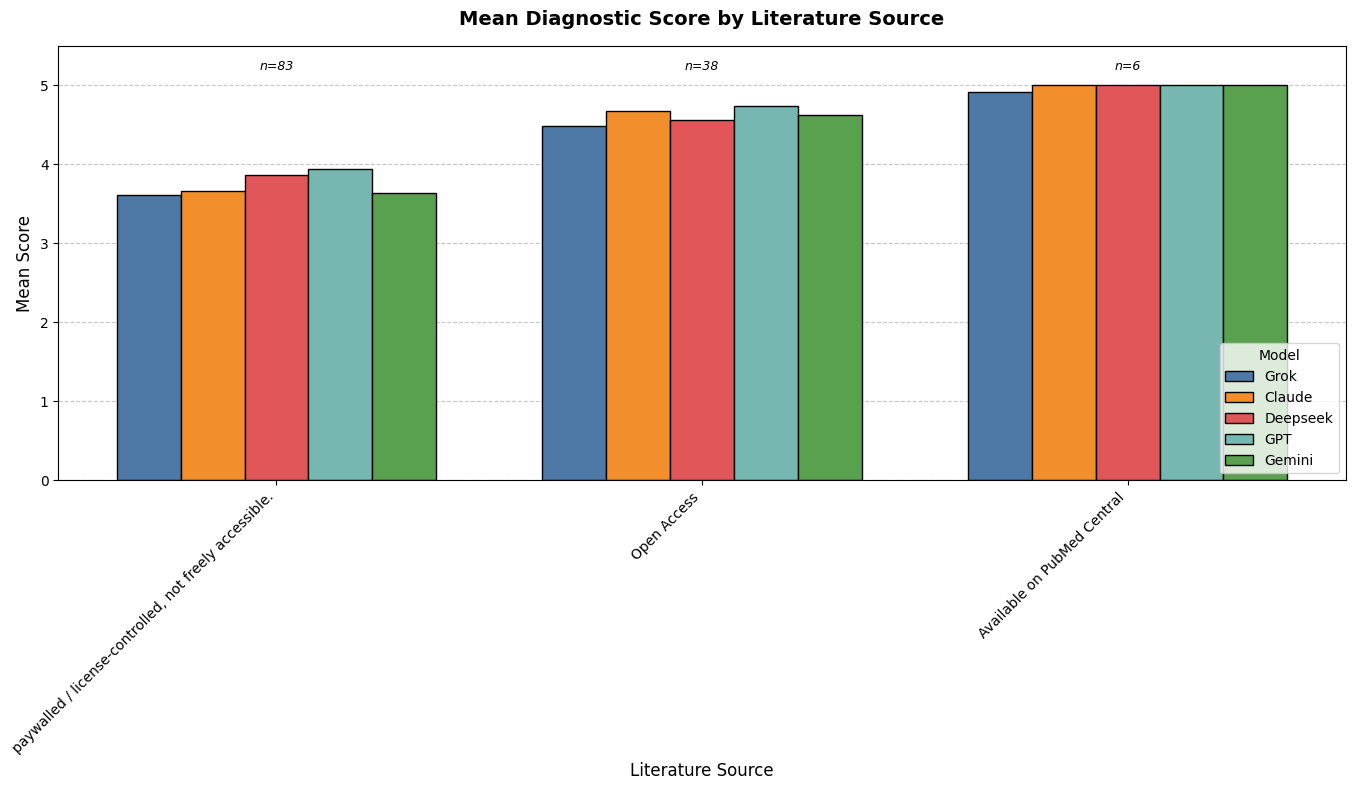

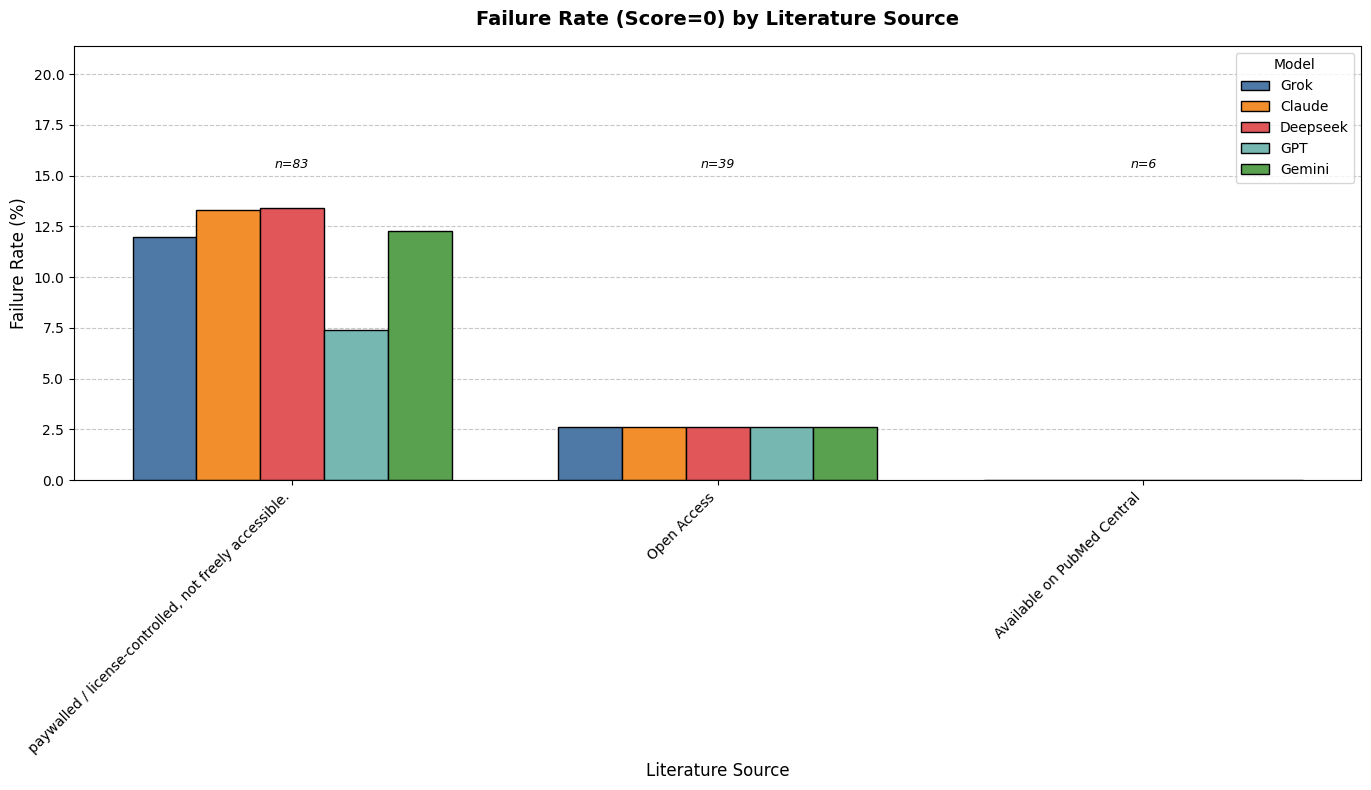

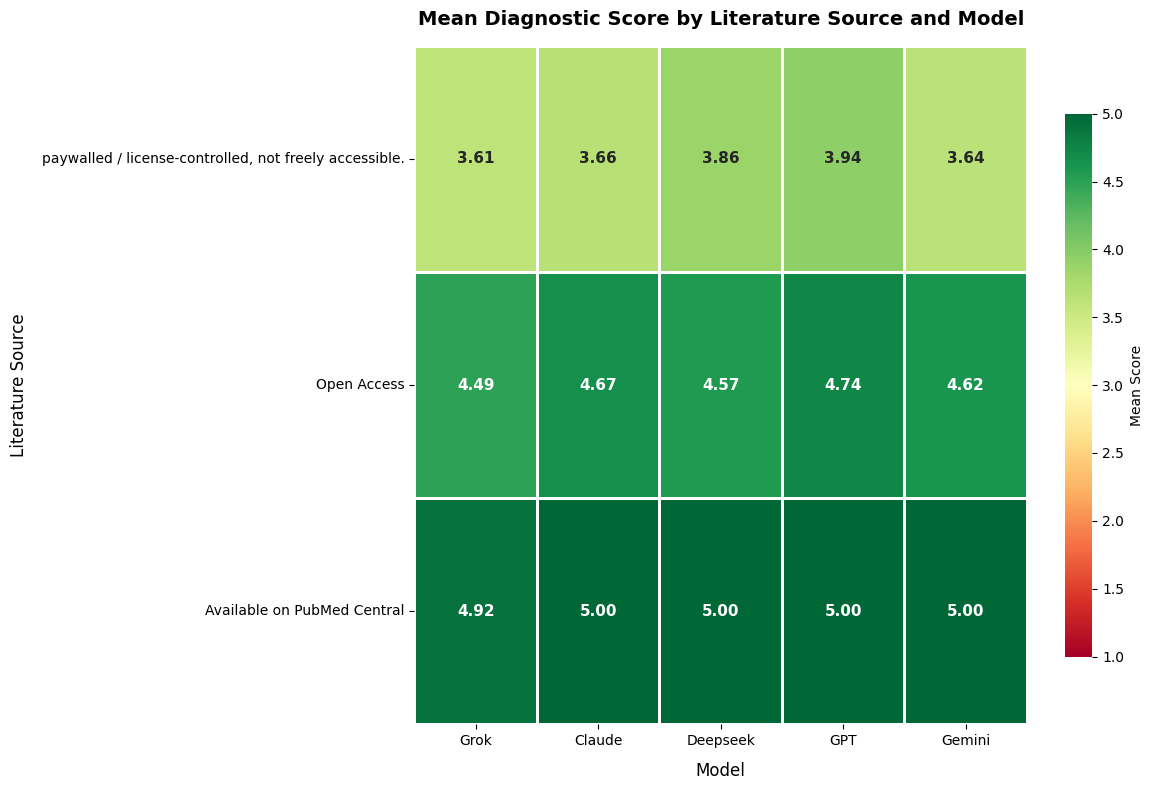

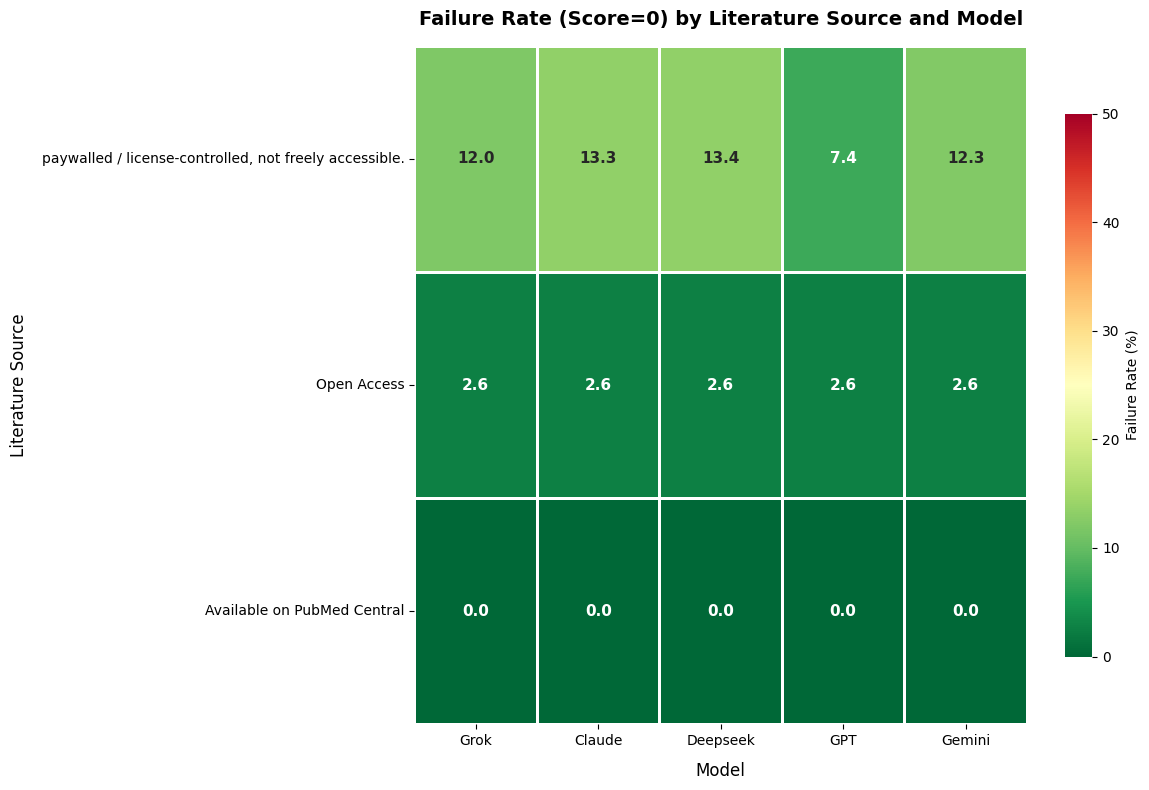

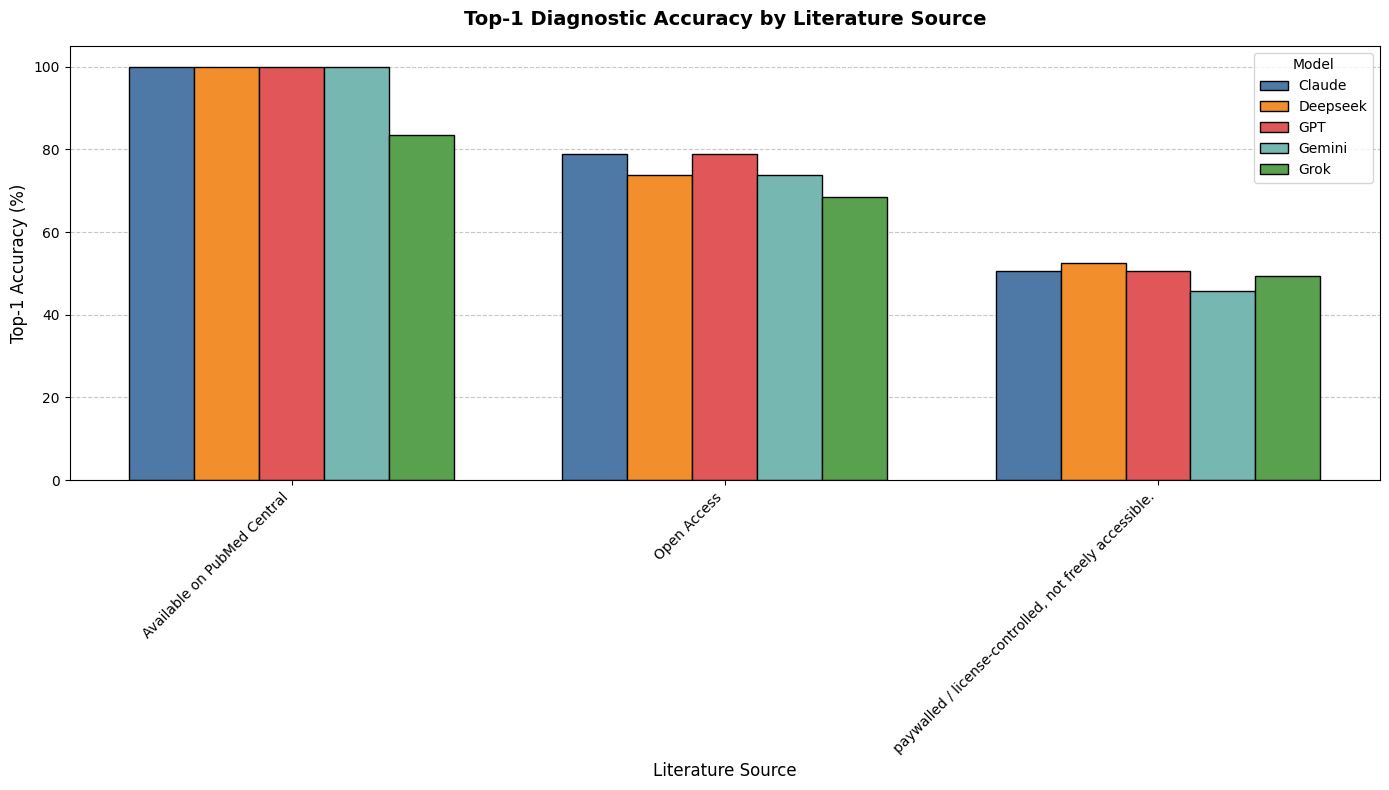


=== BEST PERFORMING SOURCE PER MODEL ===
Grok: Available on PubMed Central (Mean: 4.92)
Claude: Available on PubMed Central (Mean: 5.00)
Deepseek: Available on PubMed Central (Mean: 5.00)
GPT: Available on PubMed Central (Mean: 5.00)
Gemini: Available on PubMed Central (Mean: 5.00)

=== WORST PERFORMING SOURCE PER MODEL ===
Grok: paywalled / license-controlled, not freely accessible. (Mean: 3.61)
Claude: paywalled / license-controlled, not freely accessible. (Mean: 3.66)
Deepseek: paywalled / license-controlled, not freely accessible. (Mean: 3.86)
GPT: paywalled / license-controlled, not freely accessible. (Mean: 3.94)
Gemini: paywalled / license-controlled, not freely accessible. (Mean: 3.64)

Results exported to 'performance_by_source.xlsx'


In [14]:
# %% [code]
# === PERFORMANCE BY LITERATURE SOURCE ===

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
file_path = r"E:\test\sleep\Final_results_with_avg_scores_normalized_domains.xlsx"
df = pd.read_excel(file_path, sheet_name="Info")

# Model columns
models = ["Grok_avg", "Claude_avg", "Deepseek_avg", "GPT_avg", "Gemini_avg"]

# Check available columns to find the literature source column
print("=== AVAILABLE COLUMNS ===")
print(df.columns.tolist())

# %% [code]
# Adjust this column name based on your data
source_col = "Status"  # Change if different (e.g., "Literature_Source", "Journal", "Reference")

print(f"\n=== UNIQUE LITERATURE SOURCES ===")
print(df[source_col].value_counts())

# %% [code]
# === MEAN SCORES BY LITERATURE SOURCE ===

source_performance = df.groupby(source_col)[models].agg(['mean', 'count']).round(3)

# Flatten column names
source_performance.columns = ['_'.join(col).strip() for col in source_performance.columns]

# Get count (same for all models, take first one)
count_col = [c for c in source_performance.columns if '_count' in c][0]
source_performance['Cases'] = source_performance[count_col].astype(int)

# Keep only mean columns
mean_cols = [c for c in source_performance.columns if '_mean' in c]
source_summary = source_performance[['Cases'] + mean_cols].copy()

# Rename columns for clarity
source_summary.columns = ['Cases'] + [c.replace('_avg_mean', '') for c in mean_cols]

# Sort by number of cases
source_summary = source_summary.sort_values('Cases', ascending=False)

print("\n=== MEAN SCORES BY LITERATURE SOURCE ===")
print(source_summary.to_string())

# %% [code]
# === FAILURE RATE BY LITERATURE SOURCE ===

source_failure = []

for source in df[source_col].dropna().unique():
    source_df = df[df[source_col] == source]
    n_cases = len(source_df)
    
    row = {"Source": source, "Cases": n_cases}
    
    for model in models:
        model_name = model.replace("_avg", "")
        valid = source_df[model].notna()
        n_valid = valid.sum()
        
        if n_valid > 0:
            # Failure rate (score = 0)
            failures = (source_df.loc[valid, model] == 0).sum()
            row[f"{model_name}_Fail%"] = (failures / n_valid * 100).round(1)
            
            # Mean score
            row[f"{model_name}_Mean"] = source_df.loc[valid, model].mean().round(2)
        else:
            row[f"{model_name}_Fail%"] = np.nan
            row[f"{model_name}_Mean"] = np.nan
    
    source_failure.append(row)

source_failure_df = pd.DataFrame(source_failure)
source_failure_df = source_failure_df.sort_values("Cases", ascending=False)

print("\n=== FAILURE RATE BY LITERATURE SOURCE ===")
fail_cols = ['Source', 'Cases'] + [c for c in source_failure_df.columns if '_Fail%' in c]
print(source_failure_df[fail_cols].to_string(index=False))

# %% [code]
# === TOP-K ACCURACY BY LITERATURE SOURCE ===

def calculate_topk(scores):
    """Calculate Top-K accuracy for a series of scores"""
    valid = scores.dropna()
    n = len(valid)
    if n == 0:
        return {f"Top-{k}": np.nan for k in range(1, 6)}
    
    return {
        "Top-1": (valid == 5).sum() / n * 100,
        "Top-2": (valid >= 4).sum() / n * 100,
        "Top-3": (valid >= 3).sum() / n * 100,
        "Top-4": (valid >= 2).sum() / n * 100,
        "Top-5": (valid >= 1).sum() / n * 100,
    }

# Calculate Top-K for each source and model
topk_by_source = []

for source in df[source_col].dropna().unique():
    source_df = df[df[source_col] == source]
    
    for model in models:
        model_name = model.replace("_avg", "")
        topk = calculate_topk(source_df[model])
        topk["Source"] = source
        topk["Model"] = model_name
        topk["Cases"] = len(source_df)
        topk_by_source.append(topk)

topk_source_df = pd.DataFrame(topk_by_source)
topk_source_df = topk_source_df[["Source", "Cases", "Model", "Top-1", "Top-2", "Top-3", "Top-4", "Top-5"]]

print("\n=== TOP-K ACCURACY BY LITERATURE SOURCE AND MODEL ===")
print(topk_source_df.round(1).to_string(index=False))

# %% [code]
# === VISUALIZATION 1: Mean Scores by Literature Source ===

fig, ax = plt.subplots(figsize=(14, 8))

# Prepare data for plotting
plot_data = source_summary.reset_index()
plot_data = plot_data[plot_data['Cases'] >= 5]  # Filter sources with at least 5 cases

x = np.arange(len(plot_data))
width = 0.15
model_names = [m.replace("_avg", "") for m in models]
colors = ['#4e79a7', '#f28e2b', '#e15759', '#76b7b2', '#59a14f']

for i, model in enumerate(model_names):
    offset = (i - len(model_names)/2 + 0.5) * width
    bars = ax.bar(x + offset, plot_data[model], width, 
                  label=model, color=colors[i], edgecolor='black')

ax.set_xlabel("Literature Source", fontsize=12)
ax.set_ylabel("Mean Score", fontsize=12)
ax.set_title("Mean Diagnostic Score by Literature Source", fontsize=14, fontweight='bold', pad=15)
ax.set_xticks(x)
ax.set_xticklabels(plot_data[source_col], rotation=45, ha='right', fontsize=10)
ax.legend(title="Model", loc='lower right', fontsize=10)
ax.set_ylim(0, 5.5)
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.set_axisbelow(True)

# Add case counts on top
for i, (idx, row) in enumerate(plot_data.iterrows()):
    ax.text(i, 5.2, f"n={int(row['Cases'])}", ha='center', fontsize=9, style='italic')

plt.tight_layout()
plt.savefig("mean_score_by_source.png", dpi=300, bbox_inches='tight')
plt.show()

# %% [code]
# === VISUALIZATION 2: Failure Rate by Literature Source ===

fig, ax = plt.subplots(figsize=(14, 8))

plot_fail = source_failure_df[source_failure_df['Cases'] >= 5].copy()

x = np.arange(len(plot_fail))
width = 0.15
fail_model_cols = [c for c in plot_fail.columns if '_Fail%' in c]

for i, col in enumerate(fail_model_cols):
    model_name = col.replace("_Fail%", "")
    offset = (i - len(fail_model_cols)/2 + 0.5) * width
    bars = ax.bar(x + offset, plot_fail[col], width, 
                  label=model_name, color=colors[i], edgecolor='black')

ax.set_xlabel("Literature Source", fontsize=12)
ax.set_ylabel("Failure Rate (%)", fontsize=12)
ax.set_title("Failure Rate (Score=0) by Literature Source", fontsize=14, fontweight='bold', pad=15)
ax.set_xticks(x)
ax.set_xticklabels(plot_fail['Source'], rotation=45, ha='right', fontsize=10)
ax.legend(title="Model", loc='upper right', fontsize=10)
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.set_axisbelow(True)

# Add case counts on top
max_y = plot_fail[fail_model_cols].max().max()
for i, row in enumerate(plot_fail.itertuples()):
    ax.text(i, max_y + 2, f"n={int(row.Cases)}", ha='center', fontsize=9, style='italic')

ax.set_ylim(0, max_y + 8)

plt.tight_layout()
plt.savefig("failure_rate_by_source.png", dpi=300, bbox_inches='tight')
plt.show()

# %% [code]
# === VISUALIZATION 3: Heatmap of Mean Scores by Source ===

fig, ax = plt.subplots(figsize=(12, 8))

# Prepare heatmap data
heatmap_data = source_summary.drop(columns=['Cases']).copy()
heatmap_data = heatmap_data[heatmap_data.index.isin(source_failure_df[source_failure_df['Cases'] >= 5]['Source'])]

sns.heatmap(heatmap_data, annot=True, fmt='.2f', cmap='RdYlGn', ax=ax,
            linewidths=1, vmin=1, vmax=5,
            cbar_kws={'label': 'Mean Score', 'shrink': 0.8},
            annot_kws={'size': 11, 'weight': 'bold'})

ax.set_title("Mean Diagnostic Score by Literature Source and Model", 
             fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel("Model", fontsize=12, labelpad=10)
ax.set_ylabel("Literature Source", fontsize=12, labelpad=10)
ax.tick_params(axis='both', labelsize=10)

plt.xticks(rotation=0)
plt.yticks(rotation=0)

plt.tight_layout()
plt.savefig("score_heatmap_by_source.png", dpi=300, bbox_inches='tight')
plt.show()

# %% [code]
# === VISUALIZATION 4: Heatmap of Failure Rate by Source ===

fig, ax = plt.subplots(figsize=(12, 8))

# Prepare failure heatmap data
fail_heatmap = source_failure_df[source_failure_df['Cases'] >= 5].set_index('Source')
fail_heatmap = fail_heatmap[[c for c in fail_heatmap.columns if '_Fail%' in c]]
fail_heatmap.columns = [c.replace('_Fail%', '') for c in fail_heatmap.columns]

sns.heatmap(fail_heatmap, annot=True, fmt='.1f', cmap='RdYlGn_r', ax=ax,
            linewidths=1, vmin=0, vmax=50,
            cbar_kws={'label': 'Failure Rate (%)', 'shrink': 0.8},
            annot_kws={'size': 11, 'weight': 'bold'})

ax.set_title("Failure Rate (Score=0) by Literature Source and Model", 
             fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel("Model", fontsize=12, labelpad=10)
ax.set_ylabel("Literature Source", fontsize=12, labelpad=10)
ax.tick_params(axis='both', labelsize=10)

plt.xticks(rotation=0)
plt.yticks(rotation=0)

plt.tight_layout()
plt.savefig("failure_heatmap_by_source.png", dpi=300, bbox_inches='tight')
plt.show()

# %% [code]
# === VISUALIZATION 5: Top-1 Accuracy by Source (Best Indicator) ===

fig, ax = plt.subplots(figsize=(14, 8))

# Pivot Top-1 data
top1_pivot = topk_source_df[topk_source_df['Cases'] >= 5].pivot(
    index='Source', columns='Model', values='Top-1'
)

# Sort by mean Top-1 across models
top1_pivot['Mean_Top1'] = top1_pivot.mean(axis=1)
top1_pivot = top1_pivot.sort_values('Mean_Top1', ascending=False)
top1_pivot = top1_pivot.drop(columns=['Mean_Top1'])

x = np.arange(len(top1_pivot))
width = 0.15

for i, model in enumerate(top1_pivot.columns):
    offset = (i - len(top1_pivot.columns)/2 + 0.5) * width
    bars = ax.bar(x + offset, top1_pivot[model], width, 
                  label=model, color=colors[i], edgecolor='black')

ax.set_xlabel("Literature Source", fontsize=12)
ax.set_ylabel("Top-1 Accuracy (%)", fontsize=12)
ax.set_title("Top-1 Diagnostic Accuracy by Literature Source", fontsize=14, fontweight='bold', pad=15)
ax.set_xticks(x)
ax.set_xticklabels(top1_pivot.index, rotation=45, ha='right', fontsize=10)
ax.legend(title="Model", loc='upper right', fontsize=10)
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.set_axisbelow(True)
ax.set_ylim(0, 105)

plt.tight_layout()
plt.savefig("top1_accuracy_by_source.png", dpi=300, bbox_inches='tight')
plt.show()

# %% [code]
# === SUMMARY: BEST/WORST SOURCE PER MODEL ===

print("\n=== BEST PERFORMING SOURCE PER MODEL ===")
for model in model_names:
    col_data = source_summary[source_summary['Cases'] >= 5][model]
    best_source = col_data.idxmax()
    best_score = col_data.max()
    print(f"{model}: {best_source} (Mean: {best_score:.2f})")

print("\n=== WORST PERFORMING SOURCE PER MODEL ===")
for model in model_names:
    col_data = source_summary[source_summary['Cases'] >= 5][model]
    worst_source = col_data.idxmin()
    worst_score = col_data.min()
    print(f"{model}: {worst_source} (Mean: {worst_score:.2f})")

# %% [code]
# === EXPORT RESULTS ===

with pd.ExcelWriter("performance_by_source.xlsx") as writer:
    source_summary.to_excel(writer, sheet_name="Mean_Scores")
    source_failure_df.to_excel(writer, sheet_name="Failure_Rates", index=False)
    topk_source_df.round(1).to_excel(writer, sheet_name="TopK_Accuracy", index=False)

print("\nResults exported to 'performance_by_source.xlsx'")